In [1]:
import cobrame
import cobra
import pickle
from sympy import Basic
import math
import json
from tqdm import tqdm
from os.path import exists
import seaborn as sns
from matplotlib import pyplot as plt
import palettable
import numpy as np
from copy import deepcopy
from sklearn import preprocessing
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from me_cofactor.general_info import met_to_name, aas_to_name
from me_cofactor.me_solve_functions import solve_me_model
from me_cofactor.load_model import load_me_model
from me_cofactor.characterize_solution import *
from me_cofactor.load_model import currency_met_to_synthesis_rxn

/home/sbrg-cjlloyd/cobrapy/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


In [2]:
with open('/home/sbrg-cjlloyd/ecolime/ecolime/me_models/iJL1678b.pickle', 'rb') as f:
    me_cons = pickle.load(f)

In [3]:
prosthetic_group_mets_to_filter = ['lys__L_c','nad_c', 'nadp_c', 'ca2_c', 
                                   'cl_c', 'cobalt2_c', 'cu2_c', 'fe2_c', 
                                   'fe3_c', 'k_c', 'mg2_c', 'nadh_c', 'nadph_c',
                                   'ni2_c', 'zn2_c', 'mn2_c', 'fad_c', 'nh4_c']

In [4]:
from cobrame.util.dogma import amino_acids

In [5]:
aas = [i[:-2] for i in amino_acids.values()]

In [6]:
me = load_me_model(json=False)

12.0 protein_b3946 --> EG11905-MONOMER
10000.0
coa_p not in model
10000.0
thf_p not in model
10000.0
nadp_p not in model
10000.0
nad_p not in model
10000.0
ribflv_p not in model
10000.0
10000.0
q8_p not in model
10000.0
2dmmq8_p not in model
10000.0
mqn8_p not in model
10000.0
fmn_p not in model
10000.0
fad_p not in model


In [7]:
if not exists('/home/sbrg-cjlloyd/Desktop/aerobic.json'):
    me.reactions.EX_o2_e.lower_bound = -1000
    solve_me_model(me, 2.5, using_soplex=False)
    sol1 = me.solution
    me.reactions.EX_o2_e.lower_bound = 0
    solve_me_model(me, 2.5, using_soplex=False)
    sol2 = me.solution
    with open('/home/sbrg-cjlloyd/Desktop/aerobic.json', 'w') as f:
        json.dump(sol1.x_dict, f)
    with open('/home/sbrg-cjlloyd/Desktop/anaerobic.json', 'w') as f:
        json.dump(sol2.x_dict, f)
else:
    with open('/home/sbrg-cjlloyd/Desktop/aerobic.json', 'r') as f:
        x_dict = json.load(f)
    sol1 = cobra.core.Solution(1, x_dict=x_dict, status='optimal')
    with open('/home/sbrg-cjlloyd/Desktop/anaerobic.json', 'r') as f:
        x_dict = json.load(f)
    sol2 = cobra.core.Solution(1, x_dict=x_dict, status='optimal')

In [8]:

def get_atp_demand(me, solution=None):
    out = pd.DataFrame()
    if solution:
        me.solution = solution
    atp = me.metabolites.atp_c
    for r in atp.reactions:
        if r.metabolites[atp] > 0 and r.x >0:
            out.loc[r.reaction, 'flux'] = r.x * r.metabolites[atp]
        if r.metabolites[atp] < 0 and r.x < 0:
            out.loc[r.reaction, 'flux'] = r.x * r.metabolites[atp]
    return out['flux'].sum()

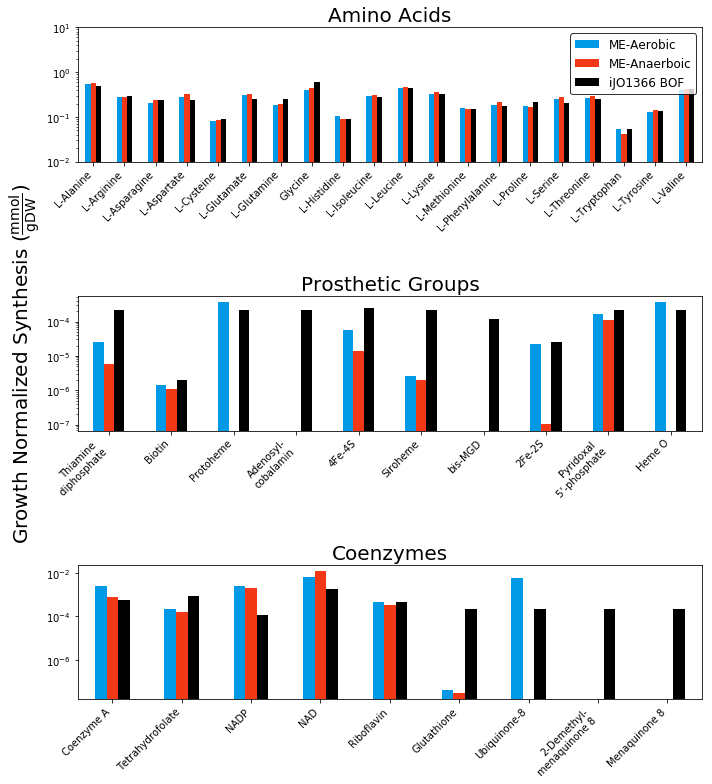

In [9]:
from matplotlib import pyplot as plt
import palettable
fig, axes = plt.subplots(3, 1, figsize=(10, 11))
#fig.subplots_adjust(hspace=.1)
from multime.auxotroph_analysis.load_model import currency_met_to_synthesis_rxn
from optaux.resources.update_mpl_rcparams import update_rcparams
update_rcparams()
met_list = []
for i, kind in enumerate(['amino_acid', 'cofactors', 'coenzymes']):
    if kind in ['amino_acid', 'cofactors']:
        comp1 = compare_to_ijo_biomass(me, solution=sol1, kind=kind)
        comp2 = compare_to_ijo_biomass(me, solution=sol2, kind=kind)
        if kind == 'cofactors':
            for met in prosthetic_group_mets_to_filter: 
                comp1.drop([met], inplace=True, errors='ignore')
                comp2.drop([met], inplace=True, errors='ignore')
    else:
        comp1 = compare_cofactor_to_ijo_biomass(me, currency_met_to_synthesis_rxn=currency_met_to_synthesis_rxn,
                                                solution=sol1)
        comp2 = compare_cofactor_to_ijo_biomass(me, currency_met_to_synthesis_rxn=currency_met_to_synthesis_rxn, 
                                                solution=sol2)
        
    logy = True
    joined = comp1.join(comp2, rsuffix='_ana')
    

    joined.rename(lambda x: x.replace("_c", ''), inplace=True)
    joined.drop('Measured_ana', axis=1, inplace=True)

    joined.columns = ['ME-Aerobic', 'iJO1366 BOF', 'ME-Anaerboic']
    
    ax = axes[i]
    
    legend=False
    if kind == 'amino_acid':
        title = 'Amino Acids'
        legend = True
    elif kind == 'cofactors':
        title = 'Prosthetic Groups'
    elif kind == 'coenzymes':
        title = 'Coenzymes'
    joined.rename(met_to_name, inplace=True)
    plt.rcParams['legend.facecolor'] = 'w'
    joined[['ME-Aerobic', 'ME-Anaerboic', 'iJO1366 BOF']].plot(kind='bar', logy=logy, ax=ax,
                                                               color=['#0099E6', '#F23814', '#000000'],
                                                               legend=legend)
    
    ax.set_xticklabels(joined.index, fontdict={'horizontalalignment': 'right', 'rotation':45})
    ax.set_title(title)
    ax.set_facecolor('w')
    met_list.extend([i for i in joined.index])
axes[0].set_ylim([.01, 10])
axes[1].set_ylabel(r'Growth Normalized Synthesis ($\mathrm{\frac{mmol}{gDW}}$)', size=20)
ax.figure.tight_layout()
ax.figure.subplots_adjust(hspace=1)
ax.figure.savefig('/home/sbrg-cjlloyd/Dropbox/_mulitme_manuscript/Figures/m_me_compare.png')

In [10]:
def rename_columns(df):
    full = False
    col_names = []
    for i in df.columns:
        if 'iron' in i:
            col_names.append('iron')
            continue
        try:
            met = me.metabolites.get_by_id(i + '_c')
        except:
            met = me.metabolites.get_by_id(i)
        if not met.name:
            met.name = met.id.replace("_c", '')
        elif met.id == 'nadp_c':
            met.name = 'nadp'
        elif met.id == 'nad_c':
            met.name = 'nad'
        elif met.id == 'fad_c':
            met.name = 'fad'
        if not full:
            met.name = met.id.replace("_c", "")
        col_names.append(met.name)

    df.columns = col_names
    return df

def get_number_of_atoms_per_metabolites(me):
    met_to_elements = {}

    for r in me.reactions.query('EX_'):
        if not r.id.startswith('EX_'):
            continue
        met = me.metabolites.get_by_id(r.id.replace("EX_", ''))
        element_dict = met.elements.copy()
        if 'H' in element_dict:
            element_dict.pop('H')

        met_to_elements[met.id] = np.array(list(element_dict.values())).sum()
        
    for m in ijo.metabolites:
        element_dict = m.elements.copy()
        if 'H' in element_dict:
            element_dict.pop('H')
        met_to_elements[m.id] = np.array(list(element_dict.values())).sum()
    return met_to_elements

def get_element_uptake_per_condition(df, met_to_elements):
    
    mol_uptake_df = pd.DataFrame()
    exchange_df = df.loc[[i for i in df.index if i.startswith('EX_')]]
    for c in exchange_df.columns:
        mol_uptake=0
        for i in exchange_df.index:
            if exchange_df.loc[i,c]< 0:
                mol_uptake += abs(exchange_df.loc[i,c] * met_to_elements[i.replace('EX_', '')])
        mol_uptake_df.loc['mol_uptake', c] = mol_uptake
    return mol_uptake_df

def get_cofactor_demand(df, growth_norm):
    out_dict = {}
    for c in tqdm(df.columns):
        x_dict = df[c].to_dict()
        sol = cobra.core.Solution(1, x_dict=x_dict, status='optimal')
        out_dict[c] = {}
        cofactors = compare_to_ijo_biomass(me, solution=sol, kind='cofactors', growth_norm=growth_norm)
        prosthetic = compare_cofactor_to_ijo_biomass(me, currency_met_to_synthesis_rxn=currency_met_to_synthesis_rxn, 
                                                     solution=sol, growth_norm=growth_norm)
        aas = compare_to_ijo_biomass(me, solution=sol, kind='amino_acid', growth_norm=growth_norm)
        out_dict[c].update(aas.drop('Measured', axis=1).to_dict().popitem()[1])
        out_dict[c]['atp'] = get_atp_demand(me, solution=sol)
        out_dict[c].update(cofactors.drop('Measured', axis=1).drop(prosthetic_group_mets_to_filter, errors='ignore').to_dict().popitem()[1])
        out_dict[c].update(prosthetic.drop('Measured', axis=1).drop(prosthetic_group_mets_to_filter, errors='ignore').to_dict().popitem()[1])
    return pd.DataFrame(out_dict).T

def split_conditional_dependent_cofactors(cluster_df):
    
    binary_df = cluster_df[cluster_df == 0].dropna(axis=1, how='all').fillna(1)
    binary_df[binary_df > 0] = 1
    cluster_df = cluster_df[cluster_df != 0].dropna(axis=1, how='any')
    
    return cluster_df, binary_df

def get_color_for_conditions(cluster_df):
    color_df = pd.DataFrame()
    color_dict = {'N': 'g', 'C': 'k', 'P':'r', 'S':'y'}
    ana_color_dict = {'N': '#90ee90', 'C': '#D3D3D3', 'P': '#ff6961', 'S': '#ffffe0'}
    for i in cluster_df.index:
        if 'anaerobic' in i:
            color_df.loc[i, 'Nutrient Source'] = ana_color_dict[i.split('_')[0]]
        else:
            color_df.loc[i, 'Nutrient Source'] = color_dict[i.split('_')[0]]
    return color_df


def summarize_conditions(df, normalize_by_element_uptake=True, growth_norm=True, split=False):

    cluster_df = get_cofactor_demand(df, growth_norm)
    if normalize_by_element_uptake:
        element_uptake_df = get_element_uptake_per_condition(df, met_to_elements)
        for i in cluster_df.index:
            cluster_df.loc[i] = cluster_df.loc[i] / element_uptake_df[i]['mol_uptake']
        
    #for met in prosthetic_group_mets_to_filter:
    #    if met in cluster_df.columns:
    #        cluster_df.drop([met], axis=1, inplace=True)
    
    # these do not consider glutathione as a substrate since it is a cofactor
    cluster_df.drop(['C_gthrd_e',
     'S_gthrd_e',
     'N_gthrd_e',
     'C_anaerobic_gthrd_e',
     'S_anaerobic_gthrd_e',
     'N_anaerobic_gthrd_e'], inplace=True, errors='ignore')
    
    if split:
        cluster_df, binary_df = split_conditional_dependent_cofactors(cluster_df)

        # most sources are the same. filter those out
        binary_df = binary_df[abs(binary_df - binary_df.median().T.sum()) != 0]

        cluster_df = rename_columns(cluster_df)
        binary_df = rename_columns(binary_df)
        return cluster_df, binary_df
    else:
        cluster_df = rename_columns(cluster_df)
        return cluster_df
met_to_elements = get_number_of_atoms_per_metabolites(me)

In [11]:
from glob import glob
full_dict = {}
for fi in glob('/home/sbrg-cjlloyd/Desktop/media_sims/*'):
    with open(fi, 'r') as f:
        x_dict = json.load(f)
    fi = fi.split('/')[-1].replace('_sol.json', '')
    if 'anaerobic' in fi:
        name = fi.replace('anaerobic_', '').replace('_EX_', '_anaerobic_')
    else:
        name = fi.replace('aerobic_', '').replace('_EX_', '_')
    full_dict[name] = x_dict
    
df = pd.DataFrame(full_dict).dropna(axis=1)

In [142]:
cluster_file = '/home/sbrg-cjlloyd/Desktop/cluster_df_new_new_new.csv'
# never uncomment, these are old simulations
#df = pd.read_csv('/home/sbrg-cjlloyd/multime/multime/auxotroph_analysis/substrates/fluxes.csv', index_col=0)
#df = df.dropna(axis=1)

#df2 = pd.read_csv('/home/sbrg-cjlloyd/multime/multime/auxotroph_analysis/substrates_anaerobic/fluxes.csv', index_col=0)
#df2 = df2.dropna(axis=1)
#df = df.join(df2)
if not exists(cluster_file):


    # TODO adding amino acid demand made this much much slower
    cluster_df = summarize_conditions(df, normalize_by_element_uptake=False, 
                                                 growth_norm=True, split=False)
    cluster_df.to_csv(cluster_file)
else:
    cluster_df = pd.read_csv(cluster_file, index_col=0)
color_df = get_color_for_conditions(cluster_df)

# reverse growth rate normalization and normalize by protein biomass
#cluster_df = (cluster_df.T * df.loc['biomass_dilution']).T
#cluster_df = (cluster_df.T / df.loc['protein_biomass_to_biomass']).T
cluster_df = cluster_df.dropna(how='all')

# PCA showing how micronutrient use differentiates conditions

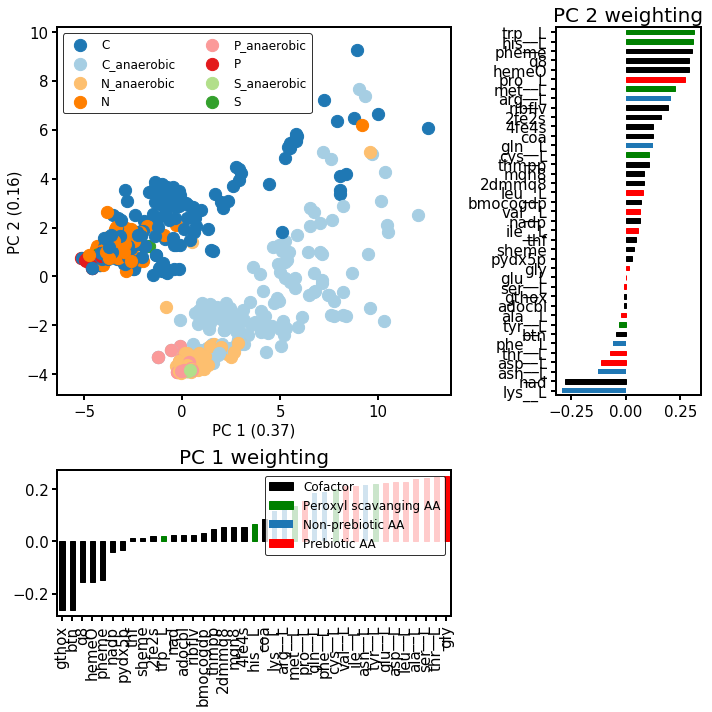

In [144]:
from collections import OrderedDict
pca_df = cluster_df.loc[[i for i in cluster_df.index]].drop('atp', axis=1)
expression_values = preprocessing.StandardScaler().fit_transform(pca_df)

pca = PCA(n_components=3)
a = pca.fit(expression_values)
X_r = a.transform(expression_values)


fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(3, 3)
ax = fig.add_subplot(gs[:-1, :-1])

source_to_color = dict(zip(['C_anaerobic', 'C', 'S_anaerobic', 'S', 'P_anaerobic', 'P', 'N_anaerobic', 'N'], 
                          palettable.colorbrewer.qualitative.Paired_8.hex_colors))

def get_shade(index):
    if 'anaerobic' in index:
        return .33
    else:
        return 1
for z in range(len(X_r[:, 0])):
    index = pca_df.index[z]
    source = index.split('_')[0] if 'anaerobic' not in index else '_'.join(index.split('_')[:2]) 
    ax.scatter(X_r[z, 0], X_r[z, 1], c=source_to_color[source], s=150, label=source)
    #ax.text(X_r[z, 0], X_r[z, 1], pca_df.index[z])
ax.set_xlabel('PC 1 (%.2f)' % a.explained_variance_ratio_[0])
ax.set_ylabel('PC 2 (%.2f)' % a.explained_variance_ratio_[1])
ax.set_facecolor('w')
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels[:-1], handles[:-1]))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', facecolor='w', ncol=2)

all_weights=pd.DataFrame()
for component in [0, 1]:
    if component == 0:
        ax = fig.add_subplot(gs[-1, :-1])
        bar_kind = 'bar'
    else:
        ax = fig.add_subplot(gs[:-1, -1])
        bar_kind = 'barh'
    ax.set_facecolor('w')
    weight_dfs = pd.DataFrame(a.components_[component], index=pca_df.columns).T
    all_weights = all_weights.join(weight_dfs.T, how='outer', rsuffix='new')
    # from https://www.pnas.org/content/110/6/2135
    # inspired by https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4906156/
    prebiotic_aas = ['ala__L', 'asp__L', 'glu__L', 'gly', 'ile__L', 
                     'leu__L', 'pro__L', 'ser__L', 'thr__L', 'val__L']
    peroyl_scavanging = ['his__L', 'cys__L', 'met__L', 'tyr__L', 'trp__L']
    weight_dfs.sort_values(0, axis=1).loc[0].plot(kind=bar_kind, ax=ax)
    for i, p in enumerate(ax.patches):
        if weight_dfs.sort_values(0, axis=1).columns[i] in prebiotic_aas:
            p.set_color('r')
            p.set_label('Prebiotic AA')
        elif weight_dfs.sort_values(0, axis=1).columns[i] in peroyl_scavanging:
            p.set_color('g')
            p.set_label('Peroxyl scavanging AA')
        elif '__L' not in weight_dfs.sort_values(0, axis=1).columns[i]:
            p.set_color('k')
            p.set_label('Cofactor')
        else:
            p.set_label('Non-prebiotic AA')
    ax.set_title('PC %i weighting' % (component+1))
    #ax.set_xlabel('Micronutrient')
    if component == 0:
        #ax.set_xticklabels(['']* len(weight_dfs.sort_values(0, axis=1).columns))
            # remove duplicate legend entries
        handles, labels = ax.get_legend_handles_labels()
        by_label = OrderedDict(zip(labels[:-1], handles[:-1]))
        ax.legend(by_label.values(), by_label.keys(), ncol=1, facecolor='w')
    else:
        pass
        #ax.set_yticklabels(['']* len(weight_dfs.sort_values(0, axis=1).columns))


fig.tight_layout()
#fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/pca_aerobic_anaerobic.svg')
all_weights.columns = ['PC 1', 'PC 2']

In [145]:
all_weights.sort_values('PC 1', ascending=False).rename(met_to_name).applymap(lambda x: '%.3f' % x).to_csv(
    '/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/pc_weightings.csv')

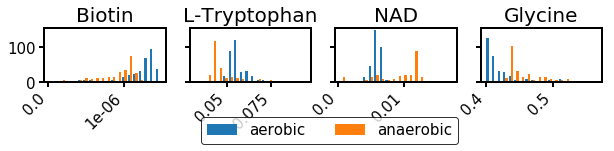

In [146]:
%matplotlib inline
hist_df = cluster_df
to_plot = list(reversed(['gly', 'nad', 'trp__L', 'btn']))
fig, axes = plt.subplots(1, 4, figsize=(10, 1), sharey=True)
for i, col in enumerate(to_plot):
    if col not in to_plot:
        continue
    ax=axes[i]
    ax.set_facecolor('w')
    if col != 'nad':
        ax.set_title(ijo.metabolites.get_by_id(col+'_c').name.replace('amide', 'amide \n'))
    else:
        ax.set_title('NAD')
    ana = [i for i in hist_df.index if 'anaerobic' in i]
    aer = [i for i in hist_df.index if 'anaerobic' not in i]
    ax.hist([hist_df.loc[aer, col], hist_df.loc[ana, col]], bins=20)
    ax.set_xticklabels([round(i, 7) for i in ax.get_xticks()], 
                  fontdict={'horizontalalignment': 'right', 'rotation':45})
ax.legend(['aerobic', 'anaerobic'], bbox_to_anchor=(-1.25, -.5), loc='upper center', fontsize=15, ncol=2,
         facecolor='w')
#axes[2].set_xlabel('Normalized Biosynthesis Flux                                             ')
    #cluster_df[col].hist(ax =ax, nbins=50)
fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/hist_for_pca.svg')

## Standard deviation analysis of nutrient sources

- TODO: look into a "core" biomass demand. Minimum of all conditions

/home/sbrg-cjlloyd/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:203 UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'


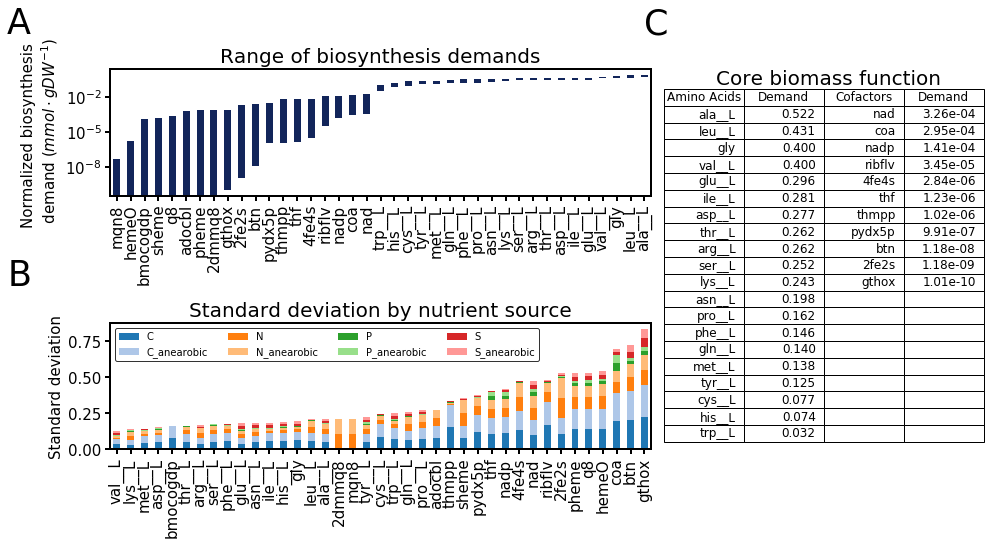

In [233]:
#fig, axes = plt.subplots(2, 1, figsize=(10, 7))
fig  = plt.figure(figsize=(15,7))
gs = fig.add_gridspec(2, 3)
ax = fig.add_subplot(gs[0,:-1])
plot_df = cluster_df.copy()#.loc[[i for i in cluster_df.index if 'anaer' not in i]]
c2, c1 = palettable.wesanderson.Zissou_5.hex_colors[0:2]
ax = plot_df.drop('atp', axis=1).max().sort_values().plot(kind='bar', logy=True,
                                                             label='max-min', ax=ax, color=c1)

ax = plot_df.drop('atp', axis=1).min().sort_values().plot(kind='bar', logy=True, ax=ax, 
                                                             color='w')
ax.set_facecolor('w')
ax.set_ylabel('Normalized biosynthesis \n demand' + r' ($mmol \cdot gDW^{-1}$)')
ax.set_title('Range of biosynthesis demands')

aer = [i for i in cluster_df.index if 'anaerob' not in i]
anaer = [i for i in cluster_df.index if 'anaerob' in i]
all_values ={}
for kind, lis in zip(['aerobic', 'anaerobic'], [aer, anaer]):
    q = cluster_df.loc[aer]/ cluster_df.loc[aer].T.max(axis=1)
    sources = set([i.split('_')[0] for i in q.index])
    
    sorted_all = q.drop('atp', axis=1).T.std(axis=1).sort_values().index

    for s in sources:
        source_rxns = [i for i in q.index if i.startswith(s)]
        key = s if kind == 'aerobic' else s+'_anearobic'
        all_values[key] =dict(zip(sorted_all, list(q.loc[source_rxns, sorted_all].T.std(axis=1).values)))

ax = fig.add_subplot(gs[1,:-1])
all_val_df = pd.DataFrame(all_values)
all_val_df['sum'] = all_val_df.sum(axis=1)
all_val_df = all_val_df.sort_values('sum')
all_val_df[sorted(all_val_df.columns)].drop(['sum'], axis=1).plot.bar(
    stacked=True, colors=palettable.tableau.Tableau_20.hex_colors, ax=ax)
ax.set_facecolor('w')
ax.legend(facecolor='w', ncol=4, fontsize=10)
ax.set_ylabel('Standard deviation')
ax.set_title('Standard deviation by nutrient source')
fig.subplots_adjust(hspace=1)
fig.text(.03, .95, 'A', size=35)
fig.text(.03, .45, 'B', size=35)
#fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/figure_3.svg')
#fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/figure_3.png')


for i in plot_df.index:
    plot_df.loc[i, 'aerobicity'] = 'anaerobic' if 'anaerobic' in i else 'aerobic'
plot_df = plot_df.drop('atp', axis=1, errors='ignore')
core_biomass = pd.DataFrame(plot_df.drop('aerobicity', axis=1).min())
core_biomass = core_biomass[core_biomass>0].dropna().sort_values(0, ascending=False)
core_biomass.index.name = 'Metabolite'
core_biomass.columns = ['Demand']
core_biomass = core_biomass.applymap(lambda x: '%.3f' % x if x>1e-3 else '{:.2e}'.format(float(x)))
core_biomass = core_biomass.reset_index()
core_out = pd.DataFrame(index=list(range(20)), columns=list(range(4)))
core_out.iloc[:20, 0] = core_biomass.iloc[:20, 0]
core_out.iloc[:20, 1] = core_biomass.iloc[:20, 1]
core_out.iloc[:11, 2] = core_biomass.iloc[20:, 0].values
core_out.iloc[:11, 3] = core_biomass.iloc[20:, 1].values
core_out.columns = ['Amino Acids', 'Demand', 'Cofactors', 'Demand']

#fig, axes = plt.subplots(1, 3)
ax = fig.add_subplot(gs[:, -1])
ax.axis('off')
ax.axis('tight')
t =ax.table(cellText=core_out.fillna('').values, colLabels=core_out.columns, loc='lower center')
t.auto_set_font_size(False)
t.set_fontsize(12)
t.scale(1.3,1.4)
fig.text(.62, .95, 'C', size=35)
fig.text(.79, .85, 'Core biomass function', size=20, ha='center')

#ax.add_patch(xy=(.75, .25))
fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/figure_3.png')
fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/figure_3.svg')

In [232]:
ax.add_patch?

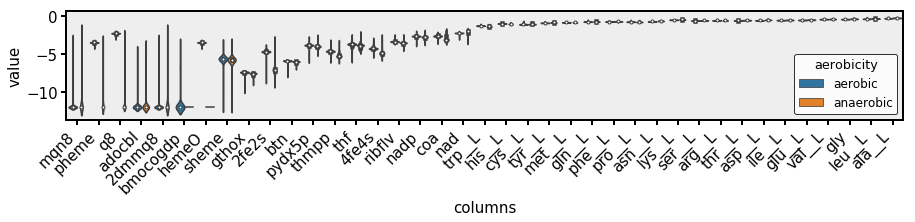

In [149]:
for i in plot_df.index:
    plot_df.loc[i, 'aerobicity'] = 'anaerobic' if 'anaerobic' in i else 'aerobic'
plot_df = plot_df.drop('atp', axis=1, errors='ignore')
boxplot_df = plot_df.melt(id_vars = 'aerobicity',
                  value_vars = [i for i in plot_df.columns if i != 'aerobicity'],
                  var_name = 'columns')
boxplot_df.value = boxplot_df.value.map(lambda x: np.log10(x+1e-12))
fig, ax = plt.subplots(figsize=(15, 2))
ax = sns.violinplot(data = boxplot_df,
                hue = 'aerobicity', 
                order=list(boxplot_df.sort_values(by='value')['columns'].unique()),
                x = 'columns',
                y = 'value', ax=ax)
t = ax.set_xticklabels(boxplot_df.sort_values(by='value')['columns'].unique(),
                   fontdict={'horizontalalignment': 'right', 'rotation':45})

/home/sbrg-cjlloyd/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:203 UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'


Text(0.5, 1.0, 'Standard deviation by nutrient source')

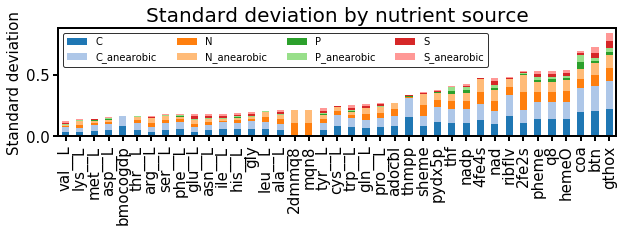

## revisit if want to optimize the cluster number in R
```library(clValid)
data = read.table('~/Dropbox (UCSD SBRG)/z_df.csv', sep=",", row.names=1,
                  header=TRUE)
intern <- clValid(data, seq(from = 10, to = 20, length.out = 10), 
                  clMethods=c("hierarchical","kmeans","pam"),
                  validation=c("internal"))
                  
q = NbClust(data, diss = NULL, distance = "euclidean",
        min.nc = 2, max.nc = 25, method = 'ward.D') 
                 ```

In [72]:
from sklearn.cluster import AgglomerativeClustering, OPTICS, KMeans, DBSCAN
from scipy.stats import ttest_ind
from sklearn.preprocessing import  RobustScaler, QuantileTransformer, MinMaxScaler
from statsmodels.stats.multitest import multipletests
from scipy.stats import ks_2samp, ranksums
p_cutoff = 1e-5
small_cluster_cutoff = 3
to_skip = ['bmocogdp', 'adocbl', '2dmmq8', 'mqn8', 'sheme']
filt_df = cluster_df.loc[[i for i in cluster_df.index if 'anaerobic' not in i]]
filt_df = filt_df[[i for i in filt_df if i != 'atp' and i not in to_skip]]
filt_df = filt_df.astype(float)#.applymap(lambda x: np.log2(x)) 
#z_df = (filt_df - filt_df.mean()) / filt_df.std()
z_df = filt_df / filt_df.max()#MinMaxScaler().fit_transform(filt_df)
z_df = pd.DataFrame(z_df, index=filt_df.index, columns=filt_df.columns)
summary=pd.DataFrame()
# cluster 45 has highest sum of signicant events across clusters
for n_clus in [6]:#range(5, 21):#[15]:#np.linspace(5, 25, 11):
    fit = AgglomerativeClustering(n_clusters=int(n_clus), linkage='ward',
                                  affinity='euclidean').fit(z_df)
    #fit = KMeans(n_clusters=n_clus).fit(z_df)
    #fit = DBSCAN(eps=.9, min_samples=2).fit(z_df)
    out_df = pd.DataFrame([z_df.index, fit.labels_], index=['met', 'cluster']).T

    drop_indexes = []
    p_df = pd.DataFrame()
    new_df = pd.DataFrame()
    sizes = []
    for clust, temp_df in out_df.groupby('cluster'):
        mets = [i for i in temp_df.met]
        
        non_clust_mets = [i for i in out_df.met if i not in mets]

        sizes.append(len(mets))
        new_df.loc[clust, 'mets'] = ', '.join(mets)
        for cofactor in z_df.columns:

            clust_values = z_df.loc[mets, cofactor].values
            non_clust_values = z_df.loc[non_clust_mets, cofactor].values
            p_df.loc[clust, cofactor] = ks_2samp(clust_values, non_clust_values)[1]
            #print(ks_2samp(clust_values, non_clust_values))
            new_df.loc[clust, cofactor] = clust_values.mean() / non_clust_values.mean()
    
    fdr_df = pd.DataFrame()
    for i in p_df.columns:
        fdr_vals = multipletests(p_df[i], alpha=p_cutoff)[1]
        fdr_df.loc[:, i] = fdr_vals
    binary_p_df = p_df.copy()
    binary_p_df[binary_p_df > p_cutoff] = 0
    binary_p_df[(binary_p_df <= p_cutoff) & ( binary_p_df >0)] = 1
            
    summary.loc[n_clus, 'num_sig'] = binary_p_df.sum(axis=1).sum()
    summary.loc[n_clus, 'num_clus'] = len(p_df.index)
    summary.loc[n_clus, 'avg_num_sig'] = binary_p_df.sum(axis=1).mean()
    summary.loc[n_clus, 'avg_size'] = np.array(sizes).mean()
    summary.loc[n_clus, 'num_sig_clus'] = (binary_p_df.sum(axis=1) > 0).sum()
    
clus_to_skip = []
for i in new_df.index:
    if len(new_df.loc[i, 'mets'].split(', ')) <= small_cluster_cutoff:
        clus_to_skip.append(i)
        
print(len(new_df.index))
summary
#out_df.sort_values(['cluster', 'met']).to_csv('/home/colton/Desktop/cluster_test.csv')
z_df.to_csv("/home/sbrg-cjlloyd/Dropbox/z_df.csv")



6


In [235]:
new_df

,mets,ala__L,arg__L,asn__L,asp__L,cys__L,glu__L,gln__L,gly,his__L,...,pydx5p,hemeO,coa,thf,nadp,nad,ribflv,gthox,q8,changes
Cluster,,,,,,,,,,,,,,,,,,,,,
0,"C_acmum_e, N_chtbs_e, N_nh4_e, C_xtsn_e, C_g3p...",0.921972,0.955742,0.928694,0.946959,0.825871,0.945862,0.878671,0.906489,0.923224,...,0.803561,0.855597,0.709594,0.698455,1.064472,1.027547,0.622784,1.584795,0.853385,"ala__L (0.92), arg__L (0.96), asn__L (0.93), a..."
1,"C_glyclt_e, C_hxan_e, C_gua_e, C_ade_e, N_pro_...",1.222798,1.193220,1.196932,1.151182,1.747007,1.158310,1.405975,1.162228,1.196527,...,0.229877,0.327980,0.334691,0.158133,0.902060,0.500498,1.873715,0.193763,0.327738,"ala__L (1.22), arg__L (1.19), asn__L (1.20), c..."
2,"C_LalaDgluMdap_e, C_galct__D_e, C_23dappa_e, C...",1.035553,1.012646,1.045748,1.035470,1.089884,1.032015,1.061359,1.053418,1.038103,...,1.150156,1.088395,1.719187,1.336651,0.868349,1.053555,0.753065,0.764839,1.094288,"ala__L (1.04), asn__L (1.05), asp__L (1.04), c..."
3,"C_ddca_e, C_dca_e, C_ocdca_e, C_ethso3_e, C_oc...",1.182418,1.107837,1.071684,1.086907,1.282860,1.095335,1.241721,1.224727,1.110809,...,0.270160,1.271880,1.533745,0.284939,0.805141,1.046463,4.847229,0.251026,1.270887,"ala__L (1.18), arg__L (1.11), asn__L (1.07), a..."
4,"C_gly_e, C_progly_e, C_for_e",1.116687,1.008753,1.176217,1.162832,1.241797,1.091797,1.144220,1.146826,1.170221,...,1.096987,1.336296,0.808733,12.102597,1.728545,0.733920,0.629453,0.476635,1.335298,
5,"N_agm_e, C_ala__L_e, N_orn_e, C_LalaDglu_e, C_...",0.993081,0.988013,1.013802,0.981701,0.998262,0.993329,0.999896,1.007772,1.024796,...,2.168863,1.372877,0.908342,0.957101,1.099722,1.008195,0.911925,0.971848,1.371614,"met__L (1.04), phe__L (1.05), trp__L (1.09), p..."


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:62 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sbrg-cjlloyd/.local/lib/python3.6/site-packages/pandas/core/generic.py:5208 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


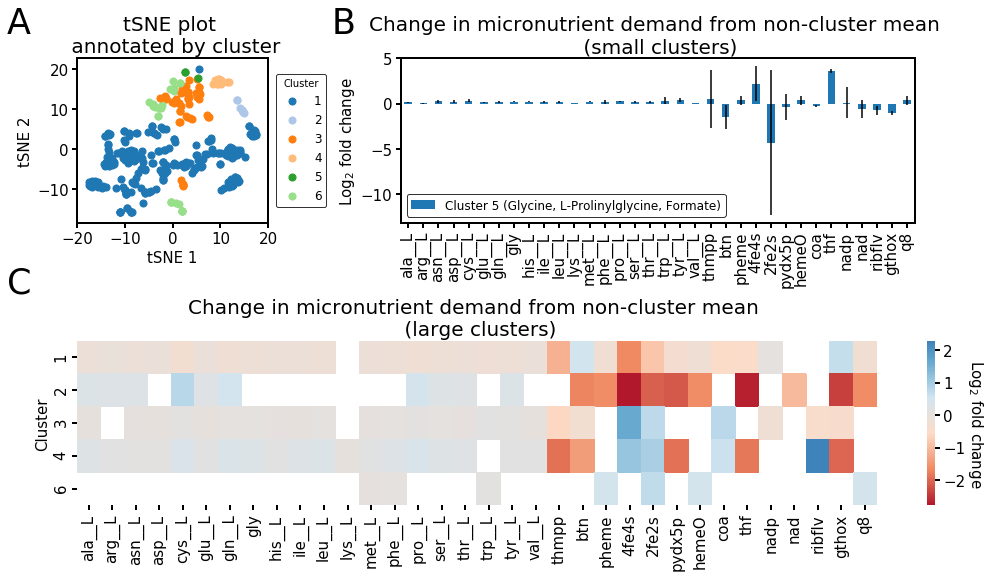

In [251]:
fig  = plt.figure(figsize=(15,8))
gs = fig.add_gridspec(2, 7)

# TSNE
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
import phate
# Z scores only for pca
phate_op = phate.PHATE(knn=200)
sne_df = z_df.copy()
#sne_df = pd.DataFrame(sne_df, index= z_df.index, columns=z_df.columns)
ax = fig.add_subplot(gs[0, :2])
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(sne_df)
#pca = PCA(n_components=2)
#X_embedded = pca.fit_transform(StandardScaler().fit_transform(sne_df))
#print(pca.explained_variance_ratio_)
#X_embedded = phate_op.fit_transform(sne_df)
clus_to_skip_temp = []
small_cluster_cutoff = 0
clust_to_color = dict(zip([i for i in new_df.index if i not in clus_to_skip_temp], 
                          palettable.tableau.Tableau_20.hex_colors))
for i, name in enumerate(filt_df.index):
    for clus in new_df.index:
        clus_mets = new_df.loc[clus, 'mets'].split(', ')
        if name in clus_mets and len(clus_mets)>(small_cluster_cutoff):

            label = 'cluster %i' % clus
            c = clust_to_color[clus]
            ax.scatter(X_embedded[i, 0], X_embedded[i, 1], c=c, label=clus, s=50)
        elif name in clus_mets:
            ax.scatter(X_embedded[i, 0], X_embedded[i, 1], c='k', label=100, s=10)
handles, labels = ax.get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if int(label)+1 not in label_list:
        handle_list.append(handle)
        label_list.append(int(label)+1)

labels = np.array(sorted(zip(label_list, handle_list)))[:, 0]
handles = np.array(sorted(zip(label_list, handle_list)))[:, 1] 
labels = ['small clusters' if str(i) == '101' else i for i in labels ]
ax.legend(handles, labels, ncol=1, bbox_to_anchor=(1.01, .5), loc='center left',
         title='Cluster', facecolor='w')
ax.set_facecolor('w')
ax.set_ylabel('tSNE 2')
ax.set_xlabel('tSNE 1')
ax.set_title('tSNE plot \n annotated by cluster')
#fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/tnse_fig.svg')


# KEEP
for i in new_df.index:
    changes = binary_p_df.loc[i][binary_p_df.loc[i] > 0].index
    add_str = ''
    for change in changes:
        add_str += ', %s (%.2f)' % (change, new_df.loc[i, change])
    new_df.loc[i, 'changes'] = add_str.strip(', ')
save_df = new_df[['mets', 'changes']]
save_df.index.name = 'Cluster'
save_df.index = save_df.index.map(lambda x: x+1)
save_df['n_mets'] = save_df.mets.map(lambda x: len(x.split(', ')))
def convert_for_table(x):
    out = ''
    for i in x.split(', '):
        out += '(%s) %s, ' % (i[0], ijo.metabolites.get_by_id(i[2:]).name)
    return out
save_df.mets = save_df.mets.map(convert_for_table)
save_df.to_csv('/home/sbrg-cjlloyd/Dropbox/cluster_df.csv')


# heatplot
ax = fig.add_subplot(gs[1,:])
mult_df = binary_p_df[binary_p_df > 0]
heat_df = new_df[[i for i in new_df.columns if i not in ['mets', 'changes']]].applymap(np.log2)
g = sns.heatmap((heat_df * mult_df).drop(clus_to_skip).rename(lambda x: x+1),
           cmap=palettable.colorbrewer.diverging.RdBu_6.get_mpl_colormap(), center=0,
           ax=ax)
g.collections[0].colorbar.set_label('Log$_2$ fold change', rotation=270,
                                    labelpad=20)
ax.set_facecolor('w')
ax.set_title('Change in micronutrient demand from non-cluster mean \n (large clusters)')


# 
ax = fig.add_subplot(gs[0,2:-1])
tmp_df = z_df.copy() # filt_df - filt_df.mean()
heat_df = pd.DataFrame()
for i in new_df.index:
    if i not in clus_to_skip:
        continue
    mets_in_clus = new_df.loc[i, 'mets'].split(', ')
    to_append_df = tmp_df.loc[mets_in_clus]
    non_clus_df = tmp_df.loc[[i for i in tmp_df.index if i not in mets_in_clus]]
    to_append_df.index = [i+1] * len(to_append_df.index)
    
    heat_df = heat_df.append(to_append_df / non_clus_df.mean())
bar_df = np.log2(heat_df)
def get_met_name(x):
    return [ijo.metabolites.get_by_id(i[2:]).name for i in x]
bar_df.index = 'Cluster ' + bar_df.index.astype(str) + new_df.loc[bar_df.index-1, 'mets'].map(
    lambda x: ' (%s)' % ', '.join(get_met_name(x.split(', '))))
mean_df = bar_df.reset_index().groupby('index').mean().T
std_df = bar_df.reset_index().groupby('index').std().T
mean_df.plot(kind='bar', yerr=std_df, ax=ax)
#ax.set_yscale('symlog')
ax.set_facecolor('w')
ax.legend(facecolor='w', loc='lower left')

ax.set_title('Change in micronutrient demand from non-cluster mean \n (small clusters)')
ax.set_ylabel(r'Log$_2$ fold change')
fig.tight_layout()
fig.text(0, .95, 'A', size=35)
fig.text(.3, .95, 'B', size=35)
fig.text(0, .5, 'C', size=35)
fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/figure_5.svg')
fig.savefig('/home/sbrg-cjlloyd/Dropbox/_me_cofactor_manuscript/Figures/figure_5.png')


In [243]:
save_df

,mets,changes,n_mets
Cluster,,,
1,"(C) N-Acetylmuramate, (N) N,N'-diacetylchitobi...","ala__L (0.92), arg__L (0.96), asn__L (0.93), a...",231
2,"(C) Glycolate, (C) Hypoxanthine, (C) Guanine, ...","ala__L (1.22), arg__L (1.19), asn__L (1.20), c...",8
3,"(C) L-alanine-D-glutamate-meso-2,6-diaminohept...","ala__L (1.04), asn__L (1.05), asp__L (1.04), c...",47
4,"(C) Dodecanoate (n-C12:0), (C) Decanoate (n-C1...","ala__L (1.18), arg__L (1.11), asn__L (1.07), a...",13
5,"(C) Glycine, (C) L-Prolinylglycine, (C) Formate,",,3
6,"(N) Agmatine, (C) L-Alanine, (N) Ornithine, (C...","met__L (1.04), phe__L (1.05), trp__L (1.09), p...",25


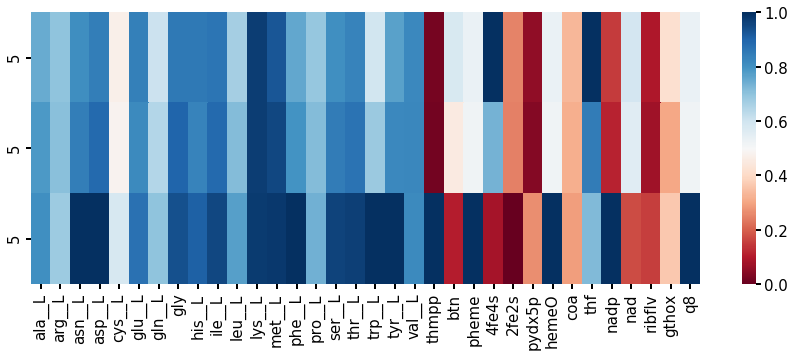

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))
a_df = z_df # filt_df - filt_df.mean()
heat_df = pd.DataFrame()
for i in new_df.index:
    if i not in clus_to_skip:
        continue
    mets_in_clus = new_df.loc[i, 'mets'].split(', ')
    to_append_df = a_df.loc[mets_in_clus]
    to_append_df.index = [i+1] * len(to_append_df.index)
    heat_df = heat_df.append(to_append_df)
sns.heatmap(heat_df, center=.5,  
              cmap=palettable.colorbrewer.diverging.RdBu_11.get_mpl_colormap(),
           ax=ax)

['C_gly_e', 'C_progly_e', 'C_for_e']


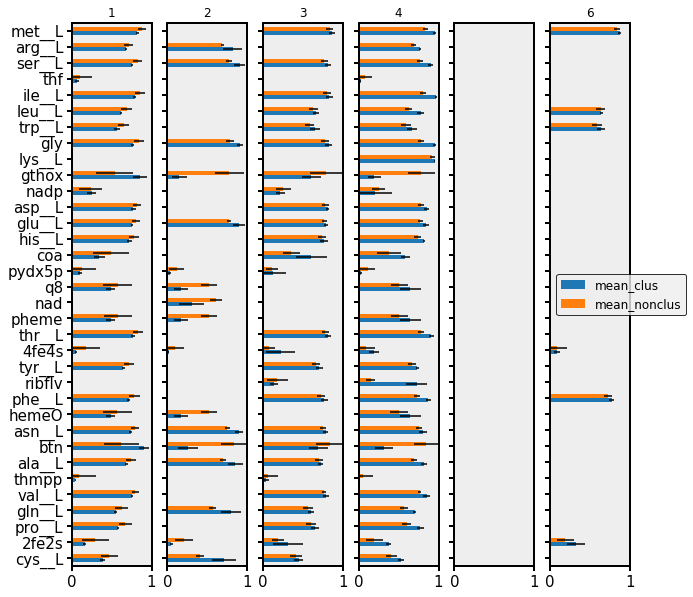

In [224]:

n_big_clus = len(new_df.index) - len(clus_to_skip)
fig, axes = plt.subplots( 1,n_big_clus, figsize=(10, 10), sharey=True, sharex=True)
axes = axes.flatten()
count=0
all_changed = []
for q in new_df.index:
    all_changed.extend([i.split(' (')[0] for i in new_df.loc[q, 'changes'].split(', ')] )
all_changed = [i for i in all_changed if i != '']
plot_df = pd.DataFrame(index=set(all_changed))

for i in new_df.index:
    if i in clus_to_skip:
        continue
        
    cluster = i
    clusts = new_df.loc[cluster, 'mets'].split(', ')
    changed = [i.split(' (')[0] for i in new_df.loc[cluster, 'changes'].split(', ')]
 
    log_df = z_df.copy()
    plot_df.iloc[:, :] = 0
    if changed ==['']:
        print(clusts)
        count+=1
        continue
    plot_df['mean_clus'] = log_df.loc[clusts, changed].mean()
    plot_df['std_clus'] = log_df.loc[clusts, changed].std()
    plot_df['mean_nonclus'] = log_df.loc[[i for i in log_df.index if i not in clusts], changed].mean()
    plot_df['std_nonclus'] = log_df.loc[[i for i in log_df.index if i not in clusts], changed].std()
    plot_df.plot(kind='barh', y=['mean_clus','mean_nonclus'], 
                 xerr=[plot_df['std_clus'], plot_df['std_nonclus']], ax=axes[count])
    axes[count].legend_ = None
    axes[count].set_title('%i' % (cluster+1), fontsize=12)
    #axes[count].plot([0,0], [0, 33], 'k--')
    axes[count].set_xlim([0, 1])
    count+=1
axes[count-1].legend()
#fig.tight_layout()

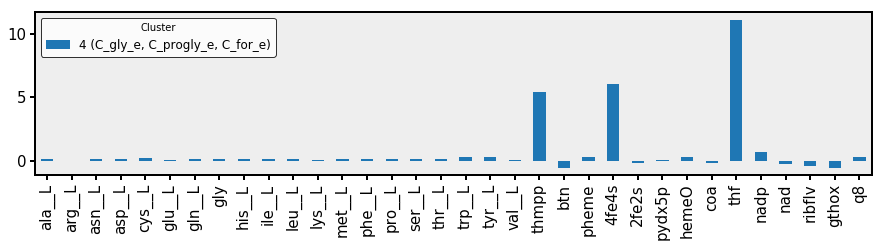

In [37]:
fig, ax = plt.subplots(figsize=(15, 3))
non_skip_df = new_df.drop([i for i in new_df.index if i not in clus_to_skip])
non_skip_df['Cluster'] = non_skip_df.index.astype(str) + non_skip_df['mets'].map(lambda x: ' (%s)' % x)
non_skip_df = non_skip_df.set_index('Cluster')
new_df_w_aas = non_skip_df[[i for i in non_skip_df.columns if i not in ['mets', 'changes']]] -1
new_df_w_aas.T.plot(kind = 'bar', ax=ax)


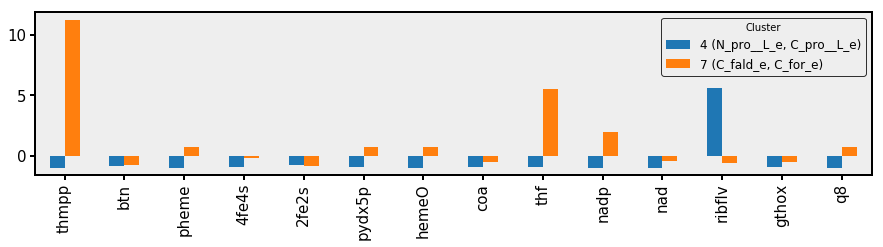

In [193]:
new_df_non_aas = non_skip_df[[i for i in new_df.columns if i not in ['mets', 'changes'] and i not in aas]] -1
new_df_non_aas.T.plot(kind = 'bar', figsize=(15, 3))

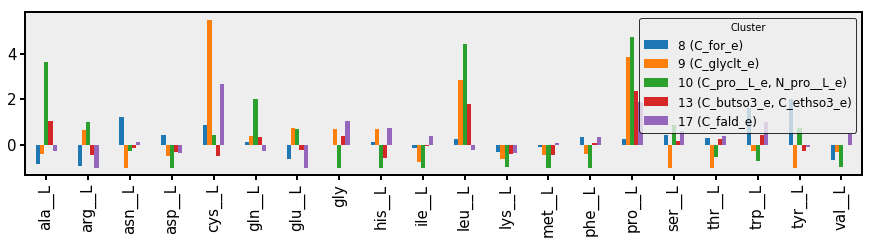

In [168]:
new_df_non_aas = non_skip_df[[i for i in new_df.columns if i not in ['mets', 'changes'] and i in aas]] -1
new_df_non_aas.T.plot(kind = 'bar', figsize=(15, 3))

In [303]:
from IPython.display import Image 
import pydotplus
from sklearn.externals.six import StringIO  

from sklearn import tree
import graphviz 

def visualize_classification_tree(fit_classifier, filtered_dataframe):
    dot_data = StringIO()
    # Get the full names of each of the columns
    feature_names = list(filtered_dataframe.columns)
    tree.export_graphviz(fit_classifier, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True, feature_names=feature_names) 
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

classifier = tree.DecisionTreeClassifier(max_depth=3, criterion='gini')

tree_df = new_df.drop(clus_to_skip)

met_cluster_df = pd.DataFrame()
for i in tree_df.index:
    for met in tree_df.loc[i, 'mets'].split(', '):
        met_cluster_df.loc[met,'cluster'] = i

In [304]:
fit_classifier = classifier.fit(z_df.loc[list(met_cluster_df.index)],
                                met_cluster_df['cluster'].values)

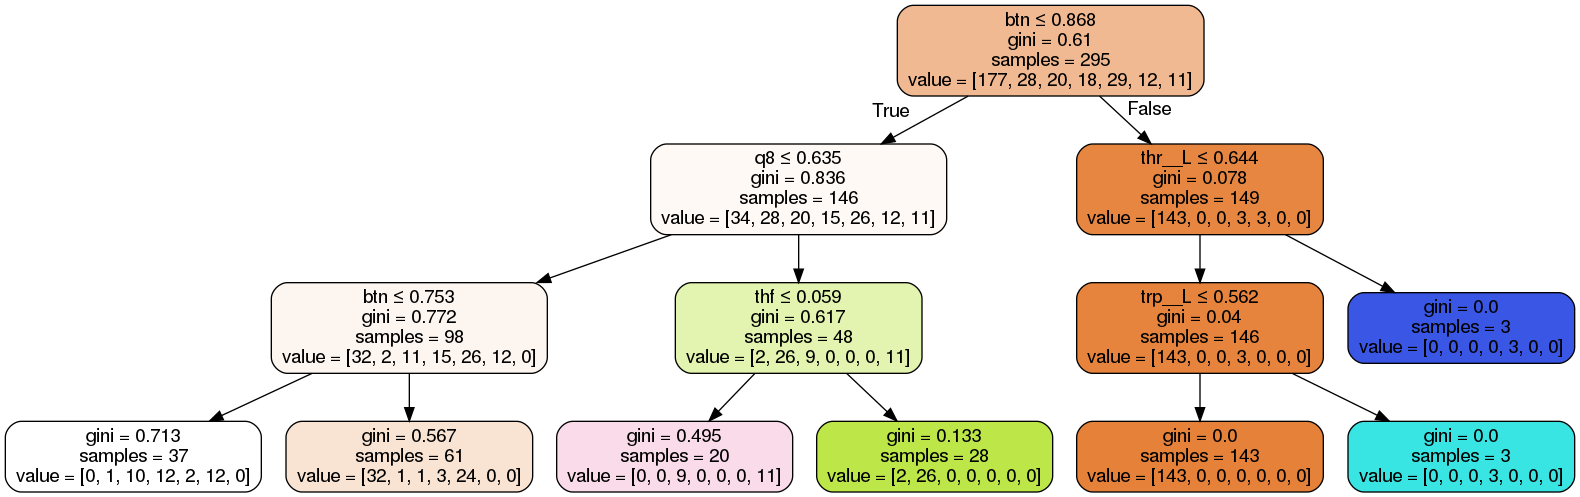

In [305]:
visualize_classification_tree(fit_classifier, z_df.loc[list(met_cluster_df.index)])


In [286]:
new_df

,mets,2fe2s,4fe4s,ala__L,arg__L,asn__L,asp__L,btn,coa,cys__L,...,q8,ribflv,ser__L,thf,thmpp,thr__L,trp__L,tyr__L,val__L,changes
cluster,,,,,,,,,,,,,,,,,,,,,
0,"C_12ppd__S_e, C_4abut_e, C_LalaDgluMdapDala_e,...",0.299638,0.130248,0.192180,0.420846,0.390758,0.453332,0.667027,0.432929,0.176128,...,0.724910,0.107451,0.577117,0.081204,0.044199,0.539243,0.494126,0.364799,0.686071,"2fe2s (0.30), 4fe4s (0.13), arg__L (0.42), asp..."
1,"C_but_e, C_butso3_e, C_dca_e, C_ddca_e, C_eths...",0.321348,0.174081,0.329491,0.406062,0.082383,0.333958,0.260716,0.490302,0.243482,...,0.636333,0.771154,0.621263,0.021226,0.014657,0.633875,0.348795,0.238808,0.571990,"2fe2s (0.32), 4fe4s (0.17), ala__L (0.33), arg..."
2,"C_14glucan_e, C_23dappa_e, C_3hcinnm_e, C_3hpp...",0.244381,0.235280,0.173971,0.498170,0.418911,0.567768,0.719997,0.487721,0.167128,...,0.507101,0.087194,0.451412,0.154522,0.044756,0.459881,0.490800,0.435961,0.631544,"asp__L (0.57), btn (0.72), gln__L (0.37), gtho..."
3,"C_23camp_e, C_23cgmp_e, C_2ddglcn_e, C_3amp_e,...",0.169772,0.059674,0.202571,0.528904,0.398697,0.530533,0.903838,0.334203,0.121968,...,0.581733,0.115855,0.479625,0.077211,0.050804,0.529754,0.361235,0.306247,0.725816,"2fe2s (0.17), 4fe4s (0.06), ala__L (0.20), arg..."
4,"C_pro__L_e, N_pro__L_e",0.035543,0.001808,0.998686,0.998992,0.279417,0.003369,0.073395,0.010632,0.223029,...,0.006813,0.711235,0.944294,0.004776,0.000478,0.264482,0.111575,0.584920,0.008981,
5,"C_dad__2_e, C_damp_e, C_dcmp_e, C_dcyt_e, C_dg...",0.135882,0.044561,0.459576,0.483310,0.165047,0.920463,0.693172,0.357575,0.260275,...,0.383754,0.065465,0.369356,0.046111,0.027580,0.822512,0.132909,0.254695,0.553770,"2fe2s (0.14), 4fe4s (0.04), ala__L (0.46), asn..."
6,"C_ade_e, C_alltn_e, C_gua_e, C_hxan_e, C_xan_e",0.046988,0.010700,0.264539,0.330567,0.712440,0.752804,0.257492,0.089421,0.555660,...,0.088502,0.144931,0.545340,0.012690,0.869820,0.835488,0.214667,0.555293,0.465868,"2fe2s (0.05), 4fe4s (0.01), arg__L (0.33), asn..."
7,"C_23ccmp_e, C_23cump_e, C_3cmp_e, C_3ump_e, C_...",0.137077,0.049826,0.239253,0.522844,0.417596,0.573100,0.822543,0.307012,0.127854,...,0.437862,0.158567,0.621300,0.081614,0.055947,0.707991,0.345170,0.326619,0.691644,"2fe2s (0.14), 4fe4s (0.05), asp__L (0.57), hem..."
8,C_for_e,0.000000,0.069150,0.039517,0.033269,0.849936,0.754377,0.077937,0.211094,0.290903,...,0.978359,0.088177,0.742587,0.644402,0.997028,0.725057,1.000000,1.000000,0.222029,


In [613]:
new_df.loc[clus_to_skip, ['mets', 'changes']].to_csv('/home/sbrg-cjlloyd/Dropbox/test.csv')

In [450]:
%matplotlib inline
cluster = 4

sig_dif = binary_p_df.loc[cluster][binary_p_df.loc[cluster] > 0].index 
sources = [i for i in new_df.loc[cluster].mets.strip("'").split(', ')]
for col in sig_dif:
    plt.hist([z_df.loc[sources, col], z_df.loc[[i for i in z_df.index if i not in sources], col]], 
             bins=50, normed=True)
    plt.title(col)
    plt.show()
    
    sns.kdeplot(z_df.loc[sources, col].values)
    sns.kdeplot(z_df.loc[[i for i in z_df.index if i not in sources], col].values)
    plt.show()

Text(0.5, 1.0, 'Number of significant metabolite differences per cluster')

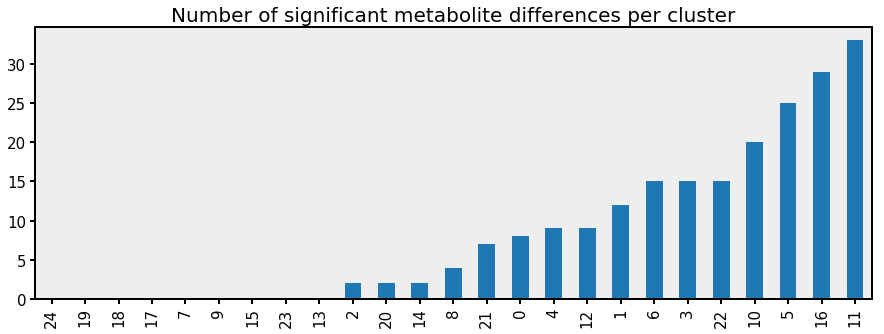

In [53]:
binary_p_df.T.sum().sort_values().plot(kind='bar', figsize=(15, 5))
plt.title('Number of significant metabolite differences per cluster')

Text(0.5, 1.0, 'Number of clusters with signficant differences in metabolite')

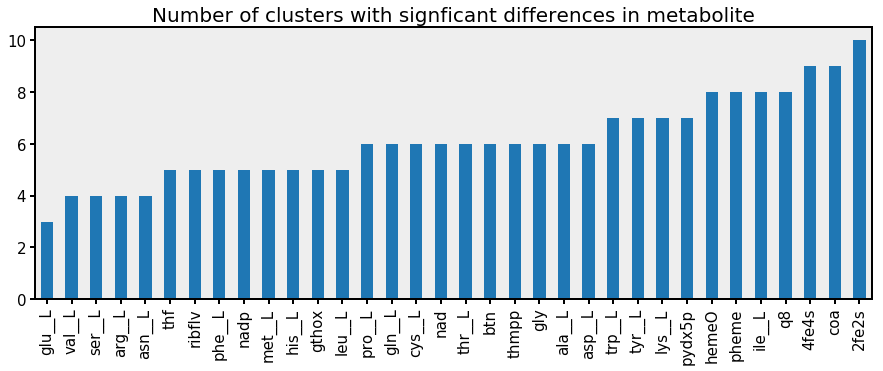

In [52]:
binary_p_df.sum().sort_values().plot(kind='bar', figsize=(15, 5))
plt.title('Number of clusters with signficant differences in metabolite')

In [163]:
from scipy.stats import ttest_ind

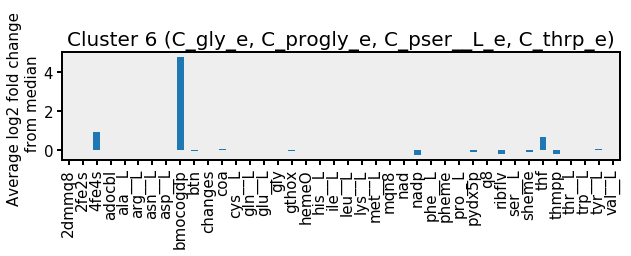

In [130]:
to_plot = [i for i in new_df.drop('mets', axis=1).columns]
for col in new_df.drop('mets', axis=1).T.columns:
    if col != 6:
        continue
    fig, ax = plt.subplots()
    log2_fc = new_df.drop('mets', axis=1)[to_plot].T[col] - new_df.drop('mets', axis=1)[to_plot].median()
    log2_fc.plot(kind='bar', figsize=(10,2), ax=ax)
    ax.set_title('Cluster %s (%s)' % (col, new_df.loc[col, 'mets']))
    ax.set_ylabel('Average log2 fold change \n from median')

In [254]:
for col in new_df.drop('mets', axis=1)[to_plot].columns:
    if col != 'atp':
        continue
    fig, ax = plt.subplots()
    log2_fc = new_df.drop('mets', axis=1)[col] - new_df.drop('mets', axis=1)[col].median()
    log2_fc.sort_values().plot(kind='bar', figsize=(5,5), ax=ax)
    ax.set_title(met_to_name.get(col, col))
    ax.set_xticks([])
    ax.set_ylabel('Average log2 fold change \n from median')
    ax.set_xlabel('Cluster')

In [449]:
ttest_ind(source_values[0], source_values[1])

Ttest_indResult(statistic=-3.4751379904014192, pvalue=0.0005953507955406158)

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:524 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


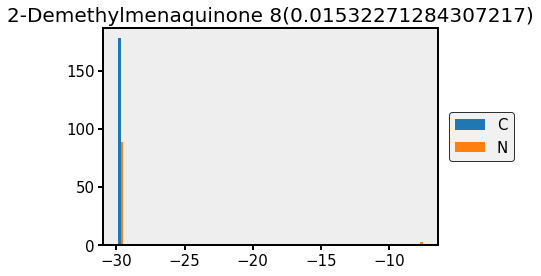

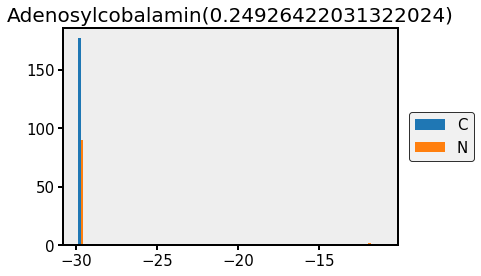

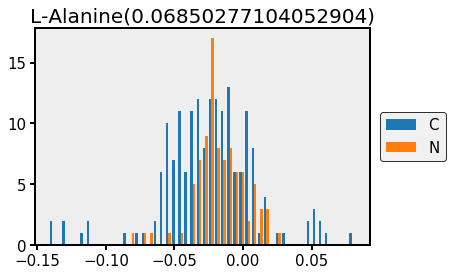

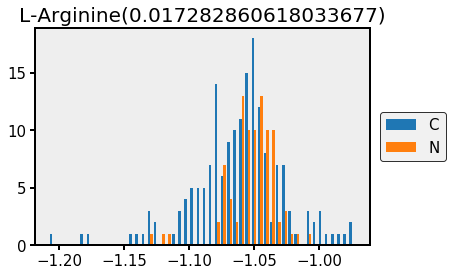

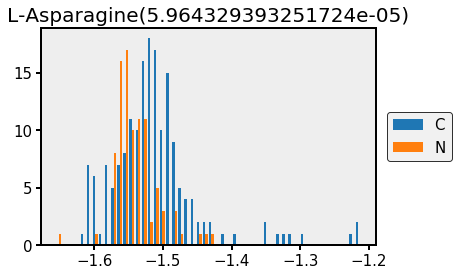

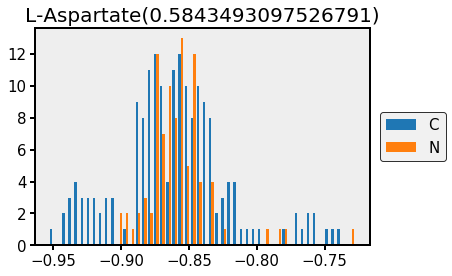

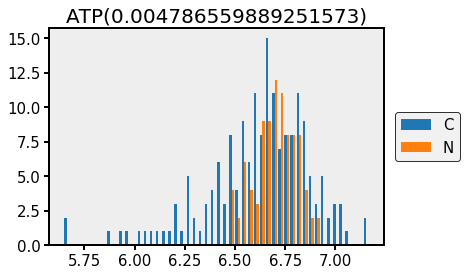

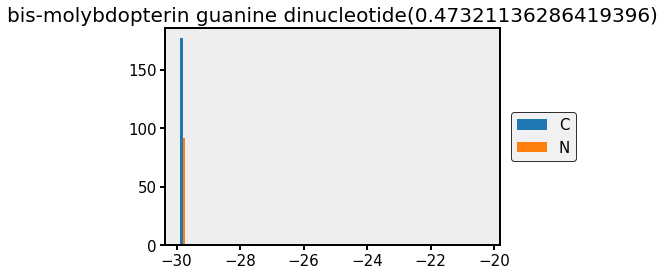

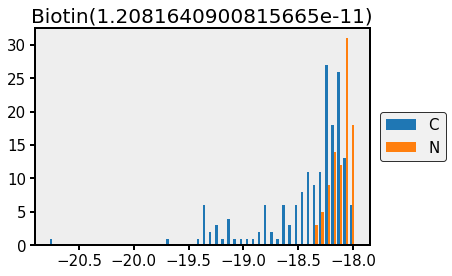

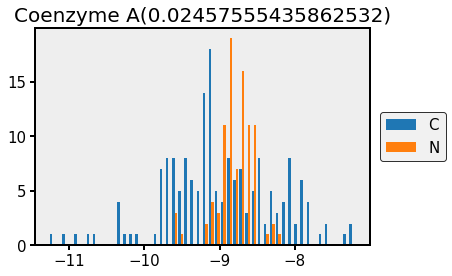

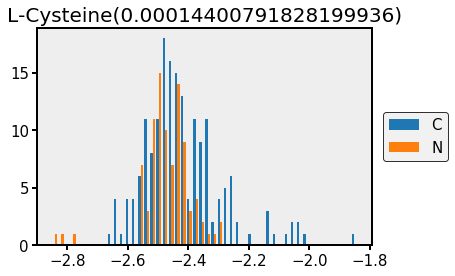

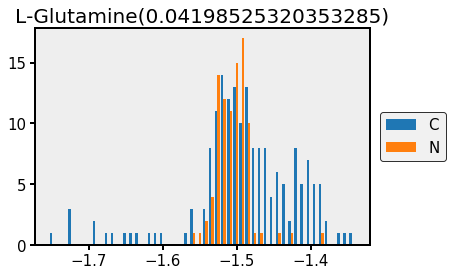

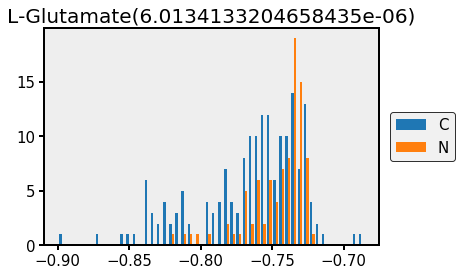

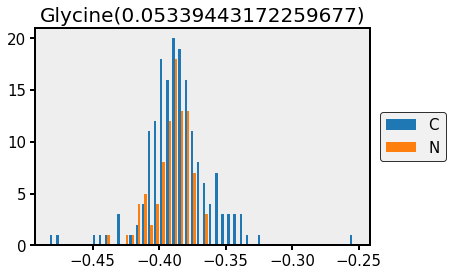

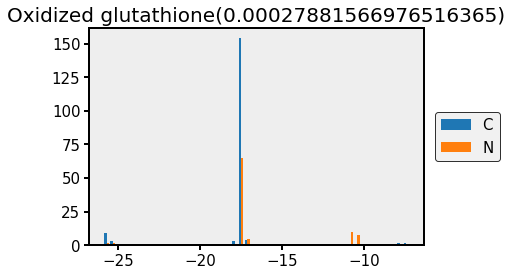

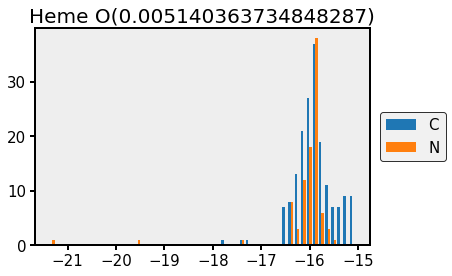

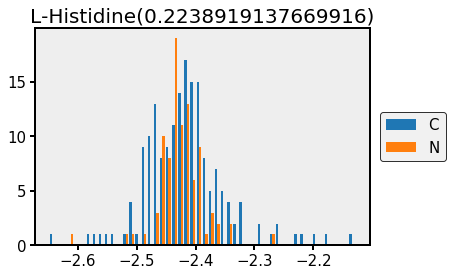

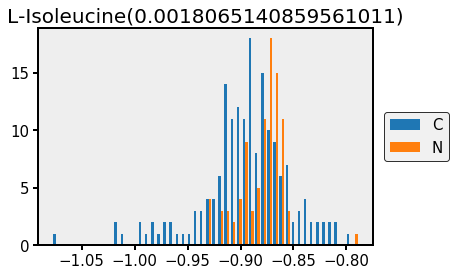

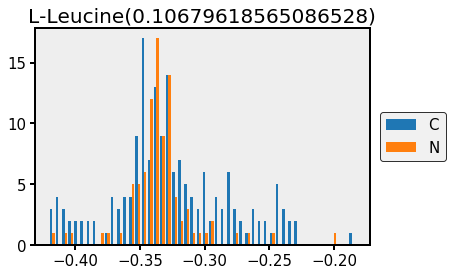

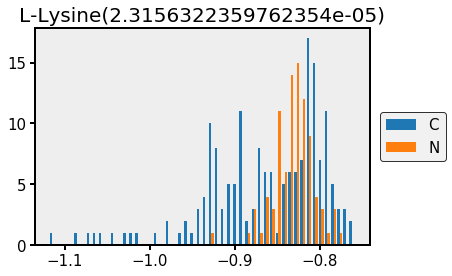

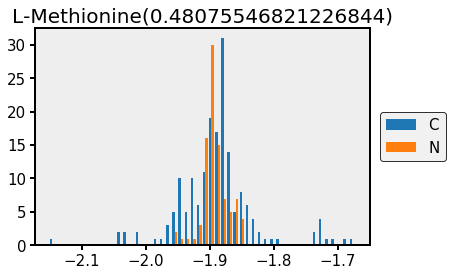

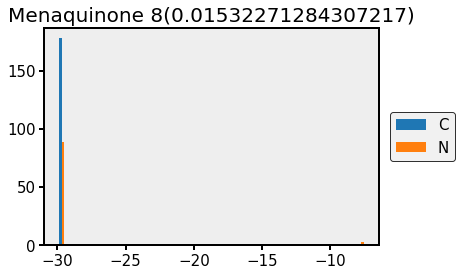

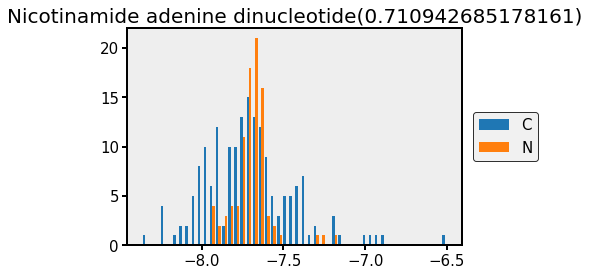

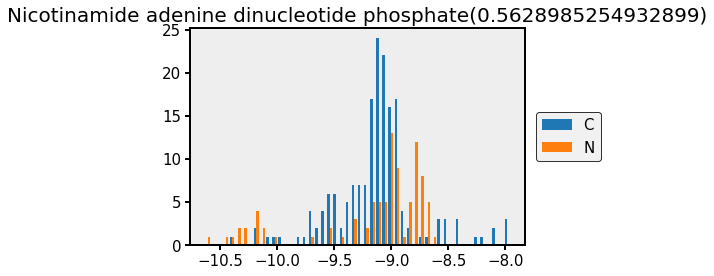

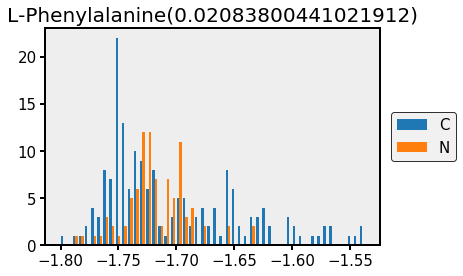

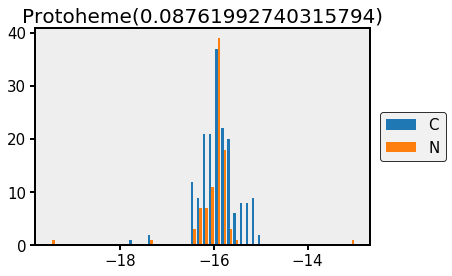

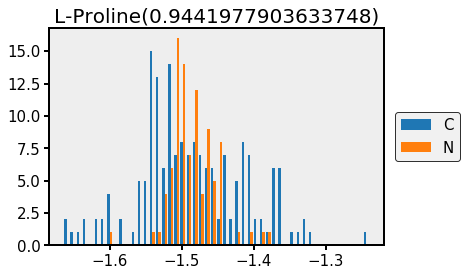

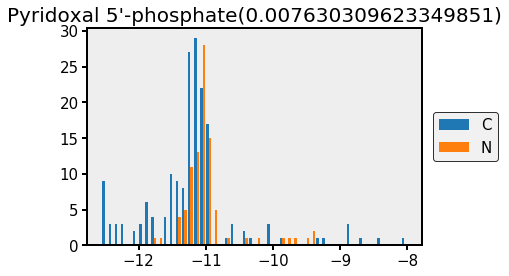

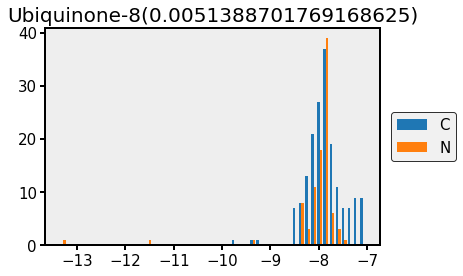

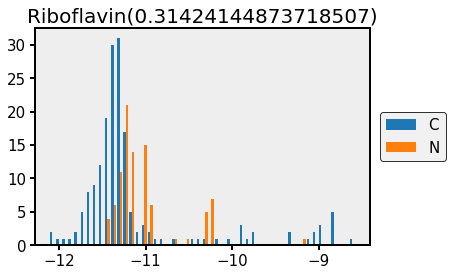

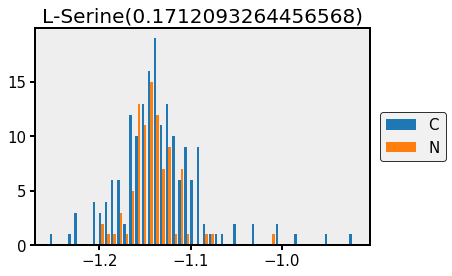

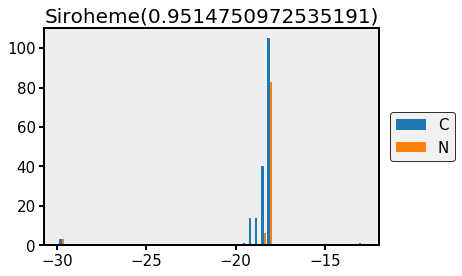

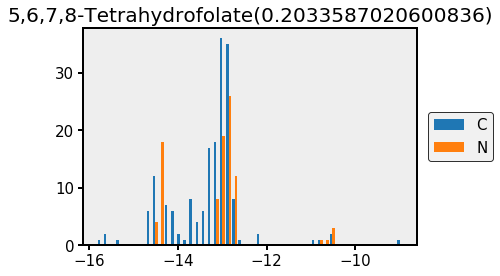

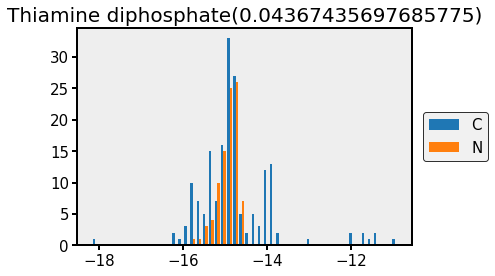

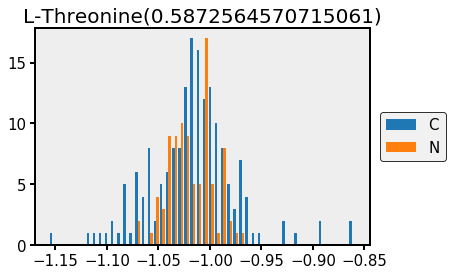

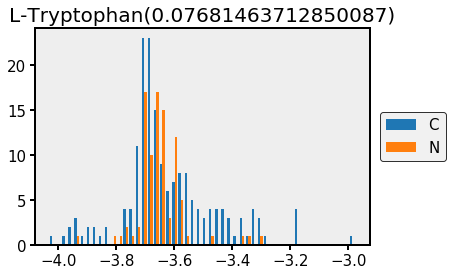

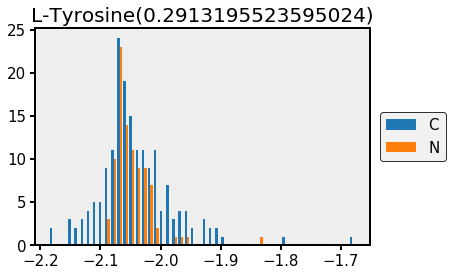

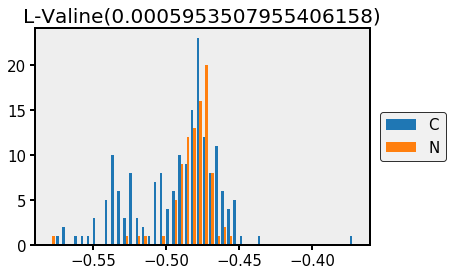

In [447]:
%matplotlib inline
hist_df = cluster_df.applymap(lambda x: np.log2(x+1e-9))
to_plot = ['asn__L', 'atp', 'btn', 'gln__L']

for i, col in enumerate(cluster_df.columns):
    fig, ax = plt.subplots(1, 1)
    source_values = []

    #ax=axes[i]
    
    sources = ['C', 'N']
    weights=[]
    for source in sources:
        source_rows = [i for i in hist_df.index if i.startswith(source) and 'anaerobic' not in i]
        weights.append([1/len(source_rows)] * len(source_rows))
        source_values.append(hist_df.loc[source_rows, col].values)
    ax.hist(source_values, bins=50, label=sources)#, weights=weights)
    ax.legend(sources, bbox_to_anchor=(1.01,.5), loc='center left', fontsize=15)
    ax.set_title(ijo.metabolites.get_by_id(col+'_c').name + '(%s)' % ttest_ind(source_values[0], source_values[1])[1])


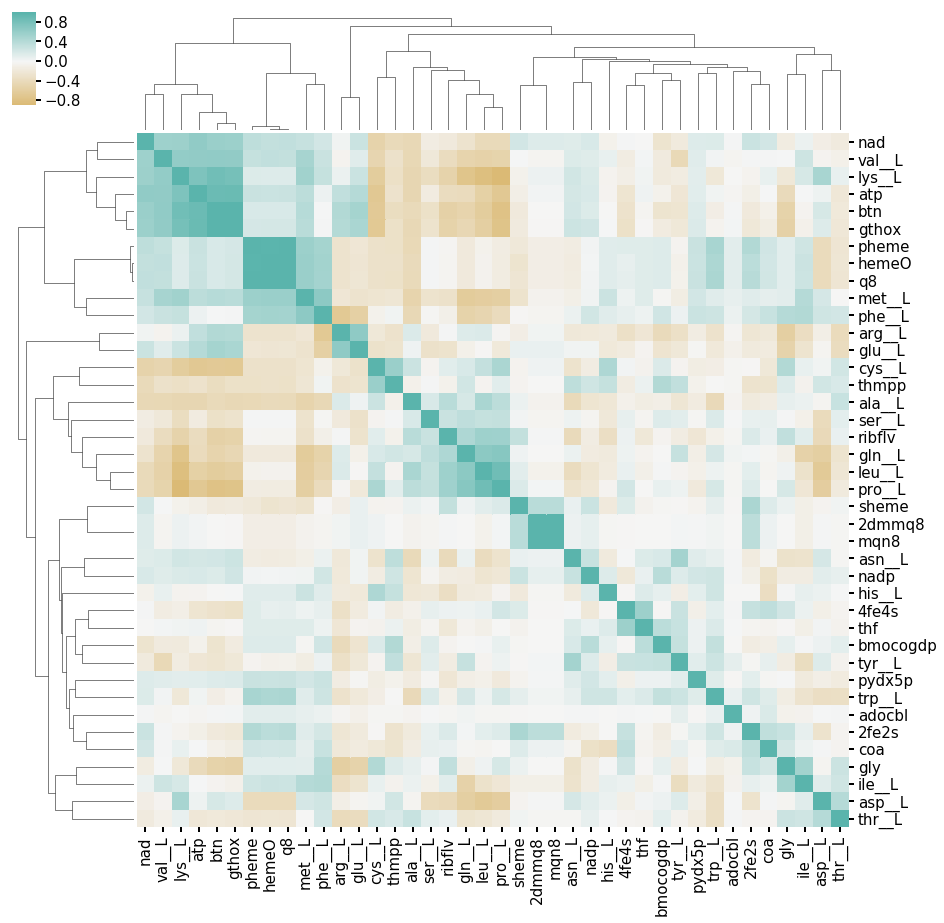

In [61]:
cmp = sns.clustermap(cluster_df.loc[[i for i in cluster_df.index if 'anaerobic' not in i]].corr(),
                     cmap=palettable.colorbrewer.diverging.BrBG_3.get_mpl_colormap(),
                  center=0, figsize=(15, 15))

In [300]:
cmp.data2d.to_csv('/home/sbrg-cjlloyd/Dropbox//test.csv')

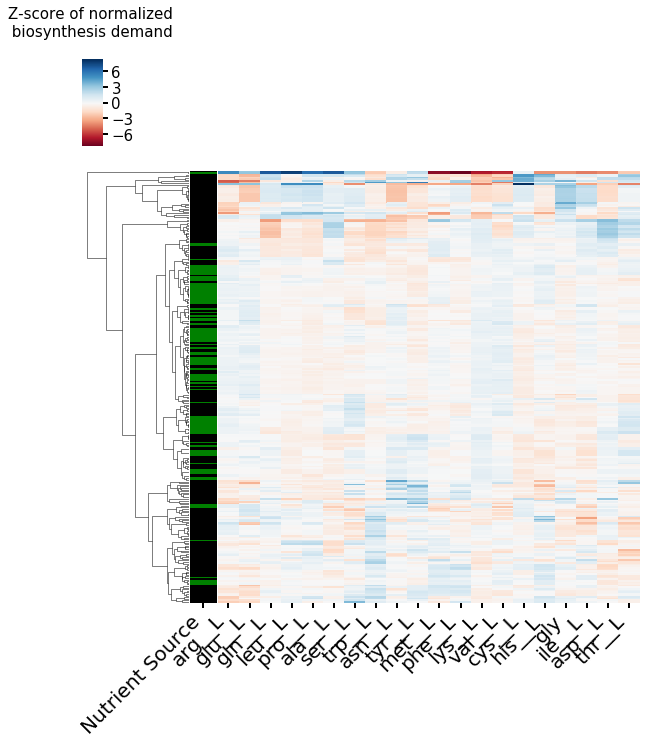

In [308]:
import seaborn as sns
from matplotlib import pyplot as plt
import palettable
log2fc_df = cluster_df[cluster_df>0].dropna(axis=1) #.applymap(np.log10)
log2fc_df = log2fc_df[[i for i in log2fc_df.columns if i in aas]]
#log2fc_df = log2fc_df[[i for i in log2fc_df.columns if i not in aas]]
log2fc_df = log2fc_df.loc[[i for i in log2fc_df.index if 'anaerobic' not in i and (i.startswith('C') or i.startswith('N'))]].dropna()
log2fc_df = (log2fc_df - log2fc_df.mean()) / log2fc_df.std()
#log2fc_df.clip(lower=-1.5, upper=1.5, inplace=True)
g = sns.clustermap(log2fc_df, method='ward',
                   row_colors=color_df, yticklabels=False,
                  cmap=palettable.colorbrewer.diverging.RdBu_11.get_mpl_colormap(),
                  center=0)
g.ax_col_dendrogram.set_visible(False)
g.ax_row_dendrogram.set_visible(True)
g.cax.set_title(r'Z-score of normalized ' + '\n biosynthesis demand \n', size=15)
q = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', size=20)
q = plt.setp(g.ax_row_colors.get_xticklabels(), rotation=45, ha='right', size=20)
plt.savefig('/home/sbrg-cjlloyd/Dropbox/always.svg')
plt.savefig('/home/sbrg-cjlloyd/Dropbox/always.png')
g.data2d.to_csv('/home/sbrg-cjlloyd/Dropbox/heatmap.csv')
#plt.setp(g.ax_heatmap.get_xticklabels(), fontdict={'horizontalalignment': 'right', 'rotation':45})

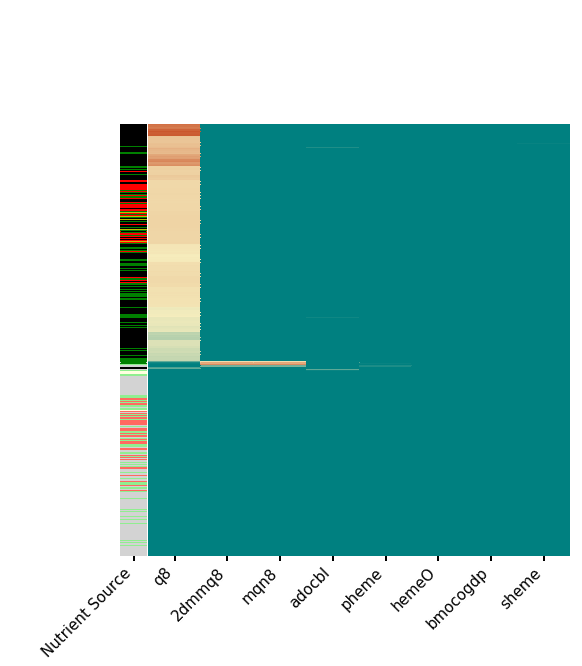

In [21]:
binary_columns = cluster_df[cluster_df==0].dropna(axis=1, how='all').columns
binary_df = cluster_df[binary_columns]
binary_df.columns = [i.replace('_c', '') for i in binary_df.columns]
g = sns.clustermap(binary_df, row_colors=color_df, yticklabels=False,
                  cmap=palettable.cartocolors.diverging.Geyser_3.get_mpl_colormap(),
                  method='ward')


g.ax_col_dendrogram.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.cax.clear()
g.cax.axis('off')

q = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right')
q = plt.setp(g.ax_row_colors.get_xticklabels(), rotation=45, ha='right')
plt.savefig('/home/sbrg-cjlloyd/Dropbox/binary.svg')
#plt.setp(g.ax_heatmap.get_xticklabels(), fontdict={'horizontalalignment': 'right', 'rotation':45})

In [202]:
name_df = pd.DataFrame()
val_df = pd.DataFrame()
save_df = pd.DataFrame()
name_to_met = {v: i for i, v in met_to_name.items()}
name_to_met['ATP'] = 'atp'
met_names = ['Coenzyme A', 'Tetrahydrofolate', 'NADP','NAD', 'Glutathione',
            'Riboflavin', 'Biotin', "Pyridoxal \n 5'-phosphate", 'Thiamine \n diphosphate', 'ATP']
met_ids =  ['thf', 'coa', 'nad', 'nadp', 'ribflv', 'btn', 'pydx5p', 'thmpp']
log2fc_df = ((log2fc_df-log2fc_df.mean())/log2fc_df.std())
for met in met_names:
    for i, source in enumerate(log2fc_df.sort_values(name_to_met[met], ascending=False)[name_to_met[met]][:3].items()):
        name = source[0][:-2]
        name = '(' + name
        if 'anaerobic' in name:
            name += '\nanaerobic'
        name = name.replace("_anaerobic_", ") ").replace("__", '-').replace('_', ') ')
        name_df.loc[met, 'min_%i' % i] = name
        val_df.loc[met, 'min_%i' % i] = source[1]
        save_df.loc[name_to_met[met], 'min_%i' % i] = source[0]
    for i, source in enumerate(log2fc_df.sort_values(name_to_met[met], ascending=False)[name_to_met[met]][-3:].items()):
        name = source[0][:-2]
        name = '(' + name
        if 'anaerobic' in name:
            name += '\nanaerobic'
        name = name.replace("_anaerobic_", ") ").replace("__", '-').replace('_', ') ').replace("gluMd", 'glu-\nMd')
        name_df.loc[met, 'max_%i' % i] = name
        val_df.loc[met, 'max_%i' % i] = source[1]
        save_df.loc[name_to_met[met], 'max_%i' % i] = source[0]
save_df.drop('nadp', inplace=True)
save_df.rename({'coa': 'pnto__R', 'nad': 'nac', 'pydx5p': 'pydxn', 'thmpp': 'thm'}, inplace=True)
save_df.to_csv('./auxotroph_analysis/aux_to_suscept.csv')

NameError: name 'log2fc_df' is not defined

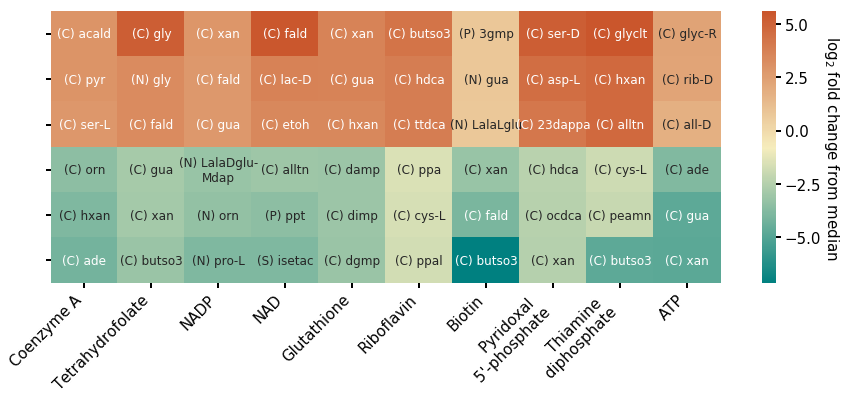

In [145]:
max_val = abs(val_df).max().max()
ax=sns.heatmap(val_df.T, annot = name_df.T, fmt='', annot_kws={'size':12},
              cmap=palettable.cartocolors.diverging.Geyser_3.get_mpl_colormap())
q = ax.set_yticklabels([''] * len(val_df.T.index))
ax.figure.set_figwidth(15)
ax.figure.set_figheight(5)
ax.collections[0].colorbar.set_label(r'log$_2$ fold change from median', rotation=270,
                                    labelpad=20)
_ = ax.set_xticklabels(val_df.index, fontdict={'horizontalalignment': 'right', 'rotation':45})
ax.figure.savefig('/home/sbrg-cjlloyd/Dropbox/substrates.svg')
ax.figure.savefig('/home/sbrg-cjlloyd/Dropbox/substrates.png')

## Auxotroph substrate analysis

In [25]:
from glob import glob
import json
ko_flux_dict = {}
for fi in tqdm(glob('/home/sbrg-cjlloyd/Desktop/auxotroph_media_sims/knockout_sims/*')):
    
    gene = fi.split('/')[-1].replace('_sol.json', '')

    with open(fi, 'r') as f:
        x_dict = json.load(f)
    if len(x_dict) > 0:
        ko_flux_dict[gene] = x_dict
ko_flux_df = pd.DataFrame(ko_flux_dict)


100%|██████████| 7680/7680 [00:20<00:00, 368.84it/s]


In [26]:
cluster_file = '/home/sbrg-cjlloyd/Desktop/cluster_df_auxotrophs.csv'

if not exists(cluster_file):


    # TODO adding amino acid demand made this much much slower
    sum_df = summarize_conditions(ko_flux_df, normalize_by_element_uptake=False, 
                                                 growth_norm=True, split=False)
    sum_df.to_csv(cluster_file)
else:
    sum_df = pd.read_csv(cluster_file, index_col=0)


100%|██████████| 4797/4797 [25:38<00:00,  3.22it/s]


In [28]:
cluster_df = (sum_df.T * ko_flux_df.loc['biomass_dilution']).T
cluster_df = (cluster_df.T / ko_flux_df.loc['protein_biomass_to_biomass']).T
def fix_atp_mu_expression(x):
    try:
        return x.subs(cobrame.mu, 0)
    except:
        return x
cluster_df['atp'] = cluster_df.atp.map(fix_atp_mu_expression)
cluster_df = cluster_df.applymap(float)
cluster_df['aux'] = cluster_df.index.map(lambda x: x.split("_")[0])
cluster_df['met'] = cluster_df.index.map(lambda x: x.split("EX_")[-1])
cluster_df['source'] = cluster_df.index.map(lambda x: x.split("_EX")[0].split('_')[-1])
cluster_df['metsource'] = cluster_df.source + '_' + cluster_df.met

In [29]:
shared_mets = {}
for aux, df in cluster_df.groupby('aux'):
    if not shared_mets:
        shared_mets = set(df.metsource.unique())
    else:
        shared_mets = shared_mets & set(df.metsource.unique())

unique_df = pd.DataFrame()
for aux, df in cluster_df.groupby('aux'):
    unique_mets = set(df.metsource.unique()) - shared_mets
    for met in unique_mets:
        unique_df.loc[aux, met] = 'x'

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:17 FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:18 FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


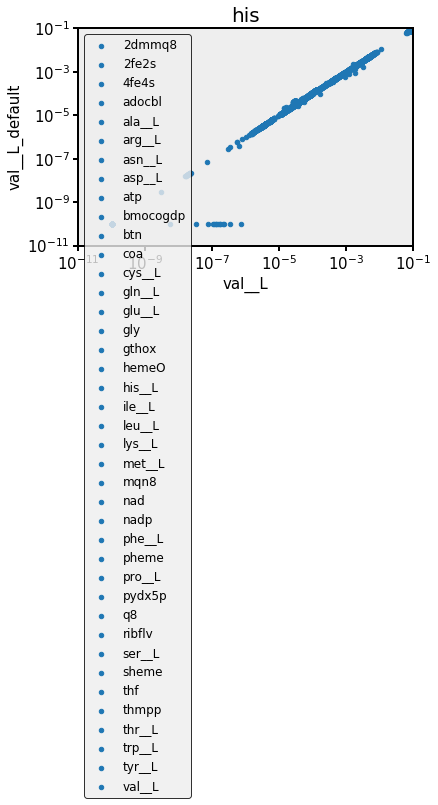

In [30]:
%matplotlib inline

default_df = cluster_df.groupby('aux').get_group('default')
for aux, aux_df in cluster_df.groupby('aux'):
    if aux != 'his':
        continue
    fig, ax = plt.subplots(1, 1)
    i=0
    for met in aux_df.columns:

        if met in ['aux', 'met', 'source', 'metsource']:
            continue

        #ax.hist(cluster_df.loc[indexes, col], bins=75, label=aux)
        default_series = default_df.set_index('metsource')[met]
        default_series.name = default_series.name + '_default'
        plot_df = pd.concat([aux_df.set_index('metsource')[met], default_series], axis=1)
        plot_df.clip_lower(1e-10, inplace=True)
        plot_df.plot(kind='scatter', x=met, y=met+'_default', label=met, ax=ax)
        if i == 11:
            i=0
        else:
            i+=1
    ax.legend()
    ax.loglog()
    ax.set_ylim(1e-11, .1)
    ax.set_xlim(1e-11, .1)
    ax.set_title(aux)
    #fig, ax = plt.subplots(1, 1)
    #ax.set_title(col)
    #ax.hist(cluster_df[col], bins=50)

    #cluster_df[col].hist(ax =ax, nbins=50)

In [31]:
skip_list = [i.split('L_')[-1].replace('EX_', '') for i in ko_flux_df.T[ko_flux_df.loc['EX_trp__L_c'] < -0.1].T.loc['EX_trp__L_c'].index]

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:524 RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


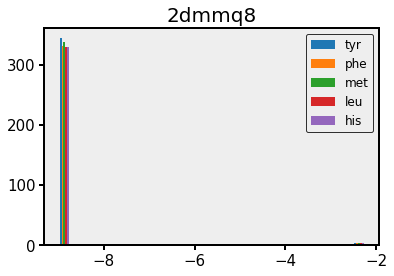

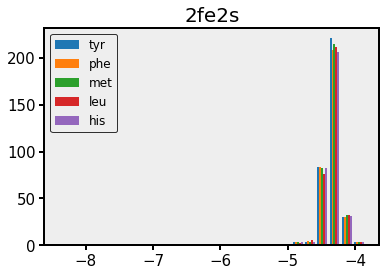

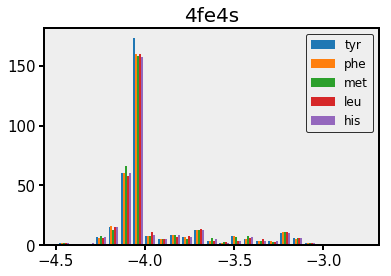

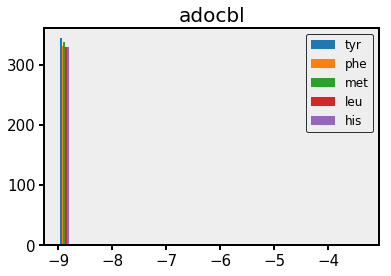

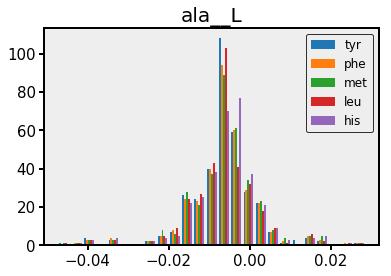

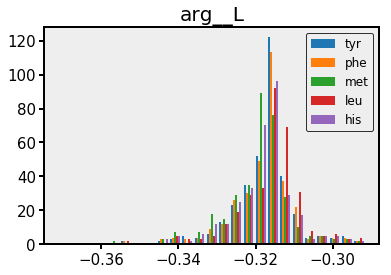

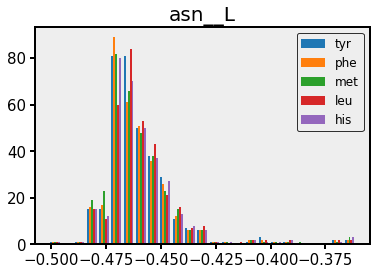

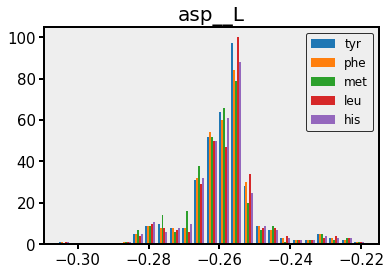

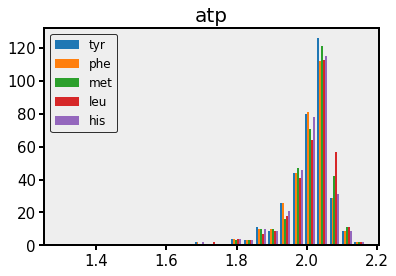

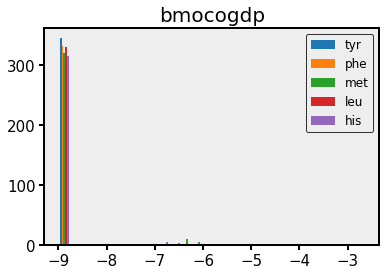

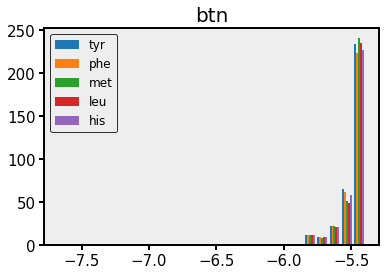

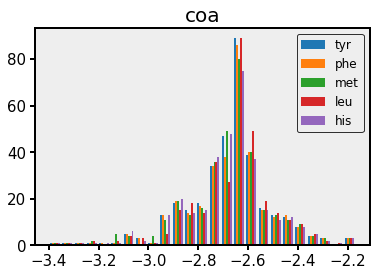

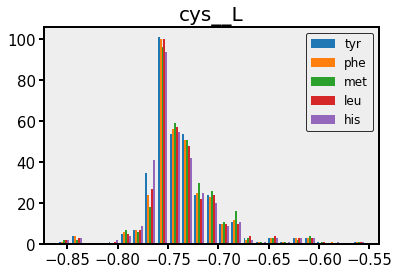

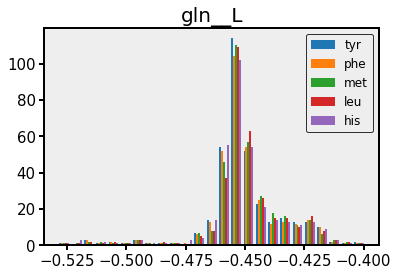

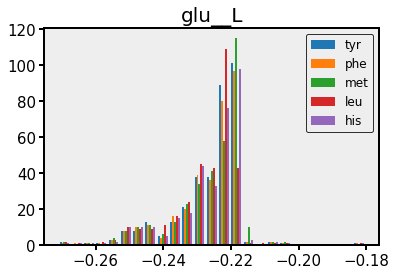

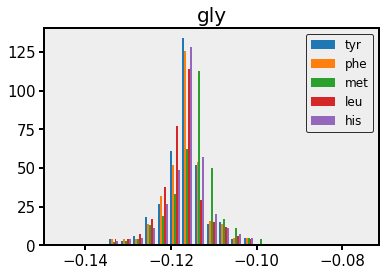

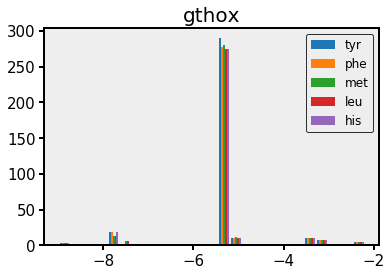

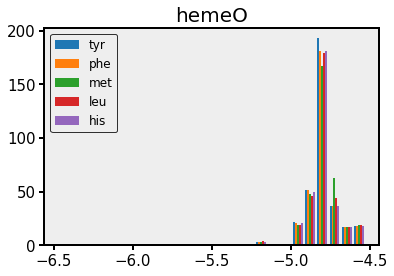

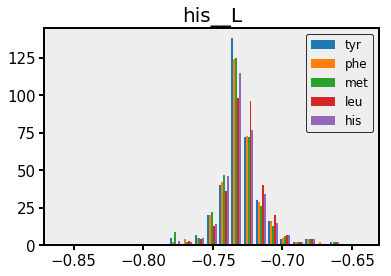

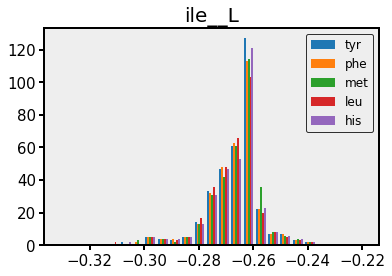

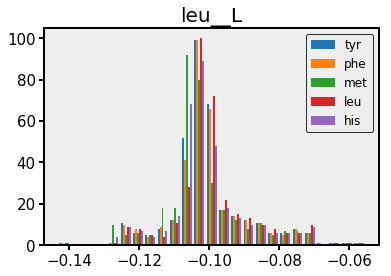

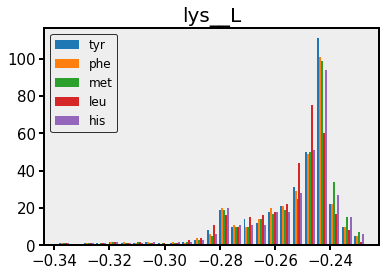

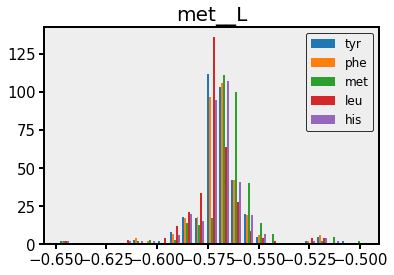

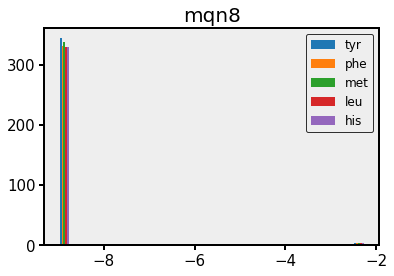

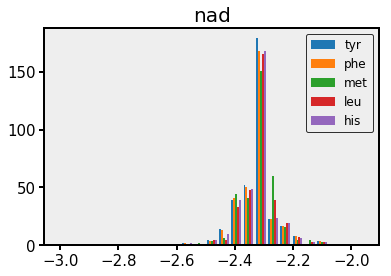

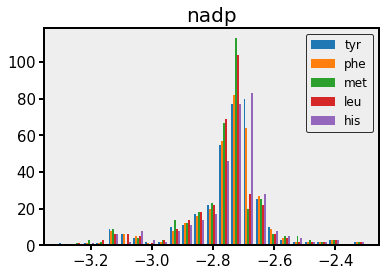

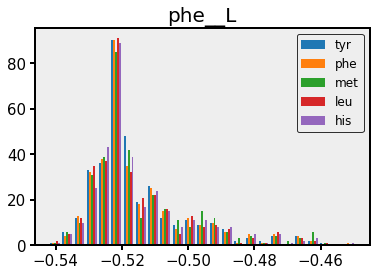

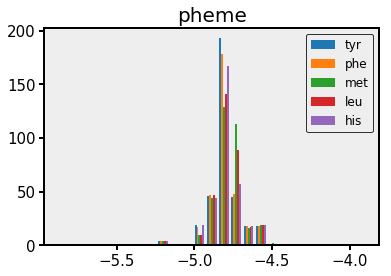

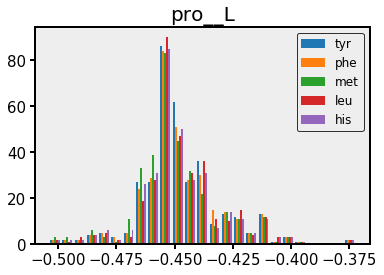

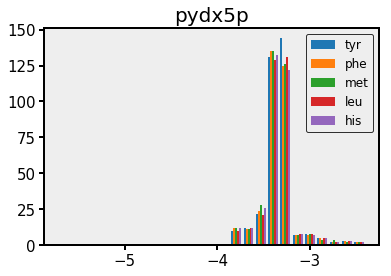

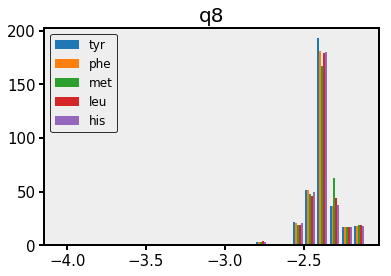

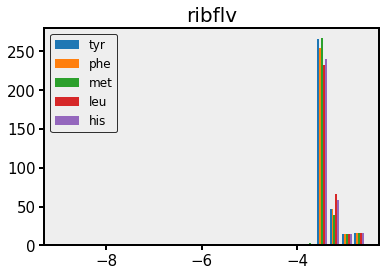

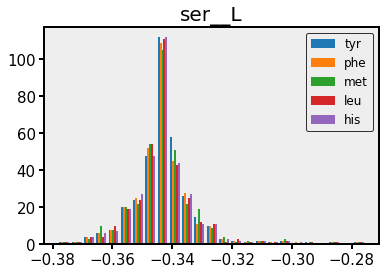

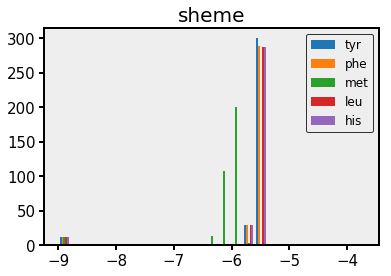

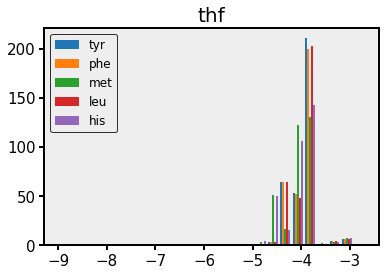

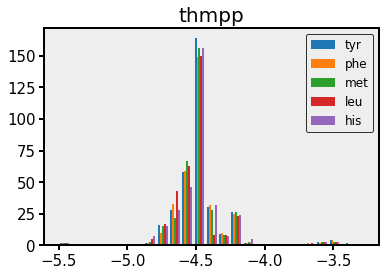

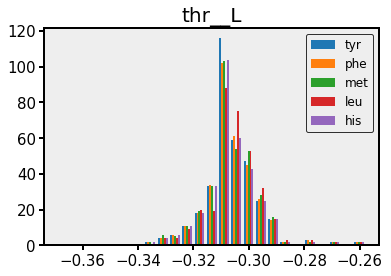

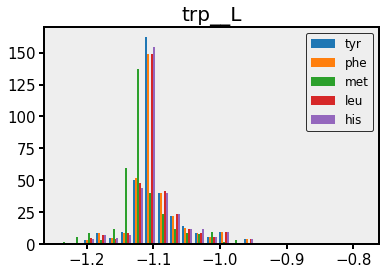

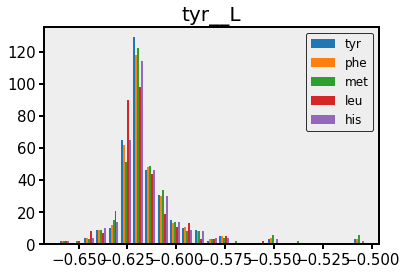

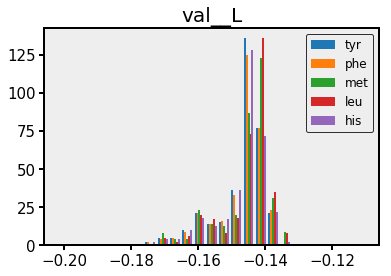

In [46]:
%matplotlib inline
no_l_aas = [i.replace('__L', '') for i in aas]

for col in cluster_df:
    hists=[]
    labels=[]
    if col in ['source', 'metsource', 'met', 'aux']:
        continue
    fig, ax = plt.subplots(1, 1)
    ax.set_title(col)
    for aux in set([i.split('_')[0] for i in cluster_df.index]):
        if aux not in no_l_aas or aux=='trp':
            continue
        auxs = [i for i in cluster_df.index if aux in i]
        hists.append(cluster_df.loc[auxs, col].map(lambda x: np.log10(x+1e-9)).values)
        labels.append(aux)
    ax.hist(hists, bins=25, label=labels)
    ax.legend()
    #fig, ax = plt.subplots(1, 1)
    #ax.set_title(col)
    #ax.hist(cluster_df[col], bins=50)

    #cluster_df[col].hist(ax =ax, nbins=50)

## Knockout analysis

In [13]:
from glob import glob
import json
ko_flux_dict = {}
for fi in glob('/home/sbrg-cjlloyd/Desktop/knockout_sims/*'):
    
    gene = fi.split('/')[-1].replace('_sol.json', '')
    ko_flux_dict[gene] = {}
    with open(fi, 'r') as f:
        try:
            x_dict = json.load(f)
        except:
            print(f)
    ko_flux_dict[gene] = x_dict
ko_flux_df = pd.DataFrame(ko_flux_dict)



In [14]:
ko_flux_df = ko_flux_df.T[ko_flux_df.loc['biomass_dilution'] > .01].T

In [15]:
cons_ko_df = get_cofactor_demand(ko_flux_df.dropna(axis=1), True)

100%|██████████| 2328/2328 [00:23<00:00, 98.89it/s] 


In [16]:
ko_df = cons_ko_df.copy()
#ko_df = ko_df.dropna(axis=1)
ko_df = ko_df[ko_df.T.sum() > 1e-4]
ko_df = ko_df.T[ko_df.sum() > 1e-9].T

In [17]:
essential_df = pd.read_csv('/home/sbrg-cjlloyd/cobrame_supplement/Table_3_model_essentiality/Monk_essentiality.csv', 
                           index_col=0)
essential_genes = essential_df[essential_df.growth < .5].KO.values
for gene in essential_genes:
    if gene in ko_df.index or gene + '_anaerobic' in ko_df.index:
        ko_df.drop(gene, inplace=True)
        ko_df.drop(gene + '_anaerobic', inplace=True, errors='ignore')
for gene in ko_df.index:
    if gene.replace('_anaerobic', '') not in essential_df['KO'].values:
        ko_df.drop(gene, inplace=True)

In [18]:
# Make dict
mol_uptake_df = pd.DataFrame()
exchange_df = ko_flux_df.loc[[i for i in ko_flux_df.index if i.startswith('EX_')]]
for c in exchange_df.columns:
    mol_uptake=0
    for i in exchange_df.index:
        if exchange_df.loc[i,c]< 0:
            mol_uptake += abs(exchange_df.loc[i,c] * met_to_elements[i.replace('EX_', '')])
    mol_uptake_df.loc['mol_uptake', c] = mol_uptake

In [19]:
for met in prosthetic_group_mets_to_filter:
    if met in ko_df.columns:
        ko_df.drop([met], axis=1, inplace=True)

In [20]:
ko_df, binary_df = split_conditional_dependent_cofactors(ko_df)

In [21]:
# run this twice to filter aerobic and anaerobic "default" solution
for q in ['_anaerobic', '']:
    default = set()
    # b0463 is a drug efflux pump and should have no impact on solutions
    mode_series = ko_df.loc['b0463%s' % q]
    for c in tqdm(ko_df.index):
        if ko_df.loc[c].equals(mode_series):
            default.add(c)
    ko_df = ko_df.drop(list(default), errors='ignore')

100%|██████████| 1185/1185 [00:00<00:00, 7253.12it/s]


In [22]:
#ros_cofactors = ['2fe2s_c', '4fe4s_c', 'hemeO_c', 'pheme_c', 'sheme_c',
#                              'q8', 'mqn8', '2dmmq8', 'ribflv']
#ko_df['iron'] = ko_df[ros_cofactors].T.sum()
#mode_series['iron'] = mode_series[ros_cofactors].sum()

In [23]:
# Normalize by element uptake
for i in ko_df.index:
    ko_df.loc[i] = ko_df.loc[i] / mol_uptake_df[i]['mol_uptake']
mode_series = mode_series / mol_uptake_df['b0463']['mol_uptake']

In [24]:
log2fc_df = ko_df.clip_lower(1e-16).applymap(math.log2) -  mode_series.clip_lower(1e-16).map(math.log2)
log2fc_df = rename_columns(log2fc_df).rename(met_to_name, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:1 FutureWarning: clip_lower(threshold) is deprecated, use clip(lower=threshold) instead


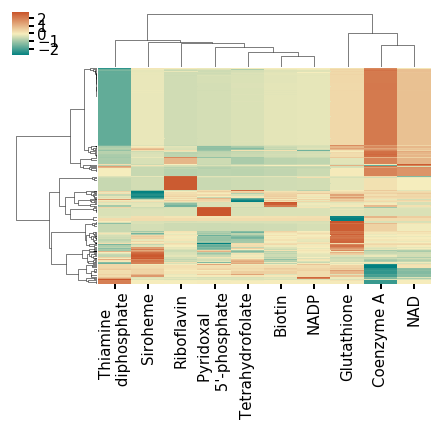

In [25]:
g = sns.clustermap(log2fc_df, z_score=0, figsize=(7.5, 5), yticklabels=False,
                  cmap=palettable.cartocolors.diverging.Geyser_3.get_mpl_colormap(),
                  method='ward')

In [26]:
ijo = cobra.io.load_json_model('/home/sbrg-cjlloyd/Desktop/ecoli_M_models/iJO1366.json')

In [27]:
name_df = pd.DataFrame()
val_df = pd.DataFrame()
met_names = ['Coenzyme A', 'Tetrahydrofolate', 'NADP','NAD', 'Glutathione',
            'Riboflavin', 'Biotin', "Pyridoxal \n 5'-phosphate", 'Thiamine \n diphosphate']
met_ids =  ['thf', 'coa', 'nad', 'nadp', 'ribflv', 'btn', 'pydx5p', 'thmpp']
for met in met_names:
    for i, source in enumerate(log2fc_df.sort_values(met, ascending=False)[met][:3].items()):
        name = source[0].split('_')[0]
        suffix = '\nanaerobic' if 'anaerobic' in source[0] else ''
        if name in ijo.genes:
            name_df.loc[met, 'min_%i' % i] = ijo.genes.get_by_id(name).name + suffix
        else:
            continue
        val_df.loc[met, 'min_%i' % i] = source[1]
    for i, source in enumerate(log2fc_df.sort_values(met, ascending=False)[met][-3:].items()):
        name = source[0].split('_')[0]
        suffix = '\nanaerobic' if 'anaerobic' in source[0] else ''
        try:
            name = ijo.genes.get_by_id(name).name
        except:
            name = name
        name_df.loc[met, 'max_%i' % i] = name + suffix
        val_df.loc[met, 'max_%i' % i] = source[1]

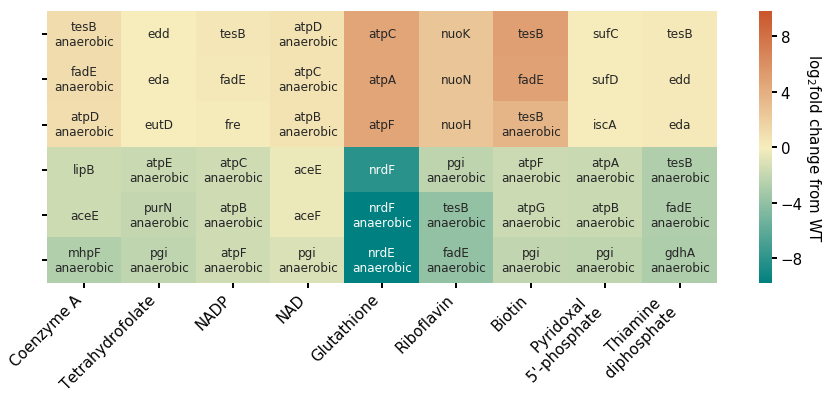

In [28]:
max_val = abs(val_df).max().max()
ax=sns.heatmap(val_df.T, annot = name_df.T, fmt='', annot_kws={'size':12},
              cmap=palettable.cartocolors.diverging.Geyser_3.get_mpl_colormap(),
              vmax=max_val, vmin=-max_val)
q = ax.set_yticklabels([''] * len(val_df.T.index))
ax.figure.set_figwidth(15)
ax.figure.set_figheight(5)
ax.collections[0].colorbar.set_label(r'log$_2$fold change from WT', rotation=270,
                                    labelpad=20)
_ = ax.set_xticklabels(val_df.index, fontdict={'horizontalalignment': 'right', 'rotation':45})
ax.figure.savefig('/home/sbrg-cjlloyd/Dropbox/substrates.svg')

## Sensitivity w/ different substrates

In [411]:
test_df = pd.read_csv('./auxotroph_analysis/titration_susceptibility/fluxes.csv', index_col=0).T

In [414]:
test_df['condition'] = ['_'.join(i.replace("__", "_").split('_')[-3:]) for i in test_df.index]
test_df['uptake'] = [float(i.split('_e_')[-1].split('_')[0]) for i in test_df.index]
test_df['aux'] = [i.split('_')[0] for i in test_df.index]

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096 SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


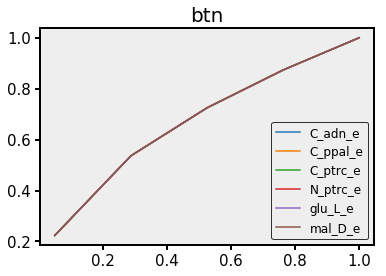

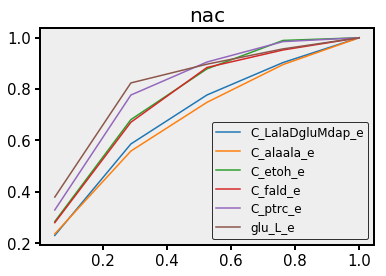

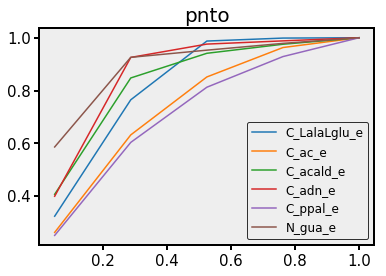

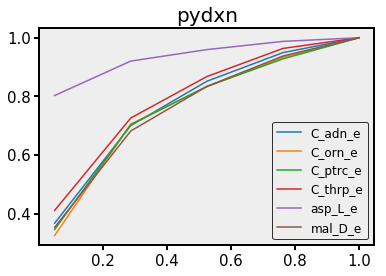

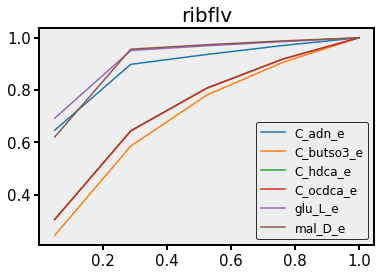

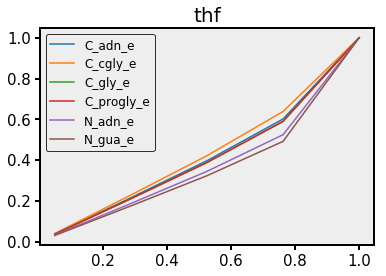

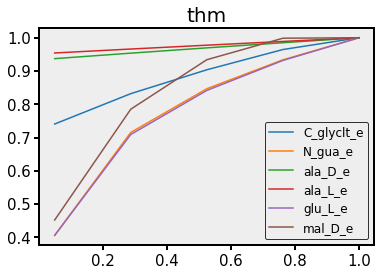

In [418]:
for aux, temp1_df in test_df.groupby('aux'):
    fig, ax = plt.subplots()
    for i, temp_df in temp1_df.groupby('condition'):
        q = temp_df
        temp_df.uptake = temp_df.uptake.map(float)
        temp_df = temp_df.sort_values('uptake')
        ax.plot(temp_df.uptake /temp_df.uptake.max() , temp_df['biomass_dilution'] /temp_df['biomass_dilution'].max(), label=i)
    ax.legend()
    ax.set_title(aux)
    #ax.semilogx()
    